[load_and_schema] Loading CSV: C:\Users\meghr\OneDrive\Desktop\Loan Eligibility Predictor\hmda_sample_preview.csv
[load_and_schema] Loaded 5000 rows and 99 columns.
[load_and_schema] Wrote schema to artifacts/schema.json
[load_and_schema] Wrote sample rows to artifacts\sample_rows.csv
Schema keys: ['source_csv', 'n_rows', 'n_columns', 'columns', 'categorical_suggestions']
[eda_quick] Loaded 5000 rows, 99 cols


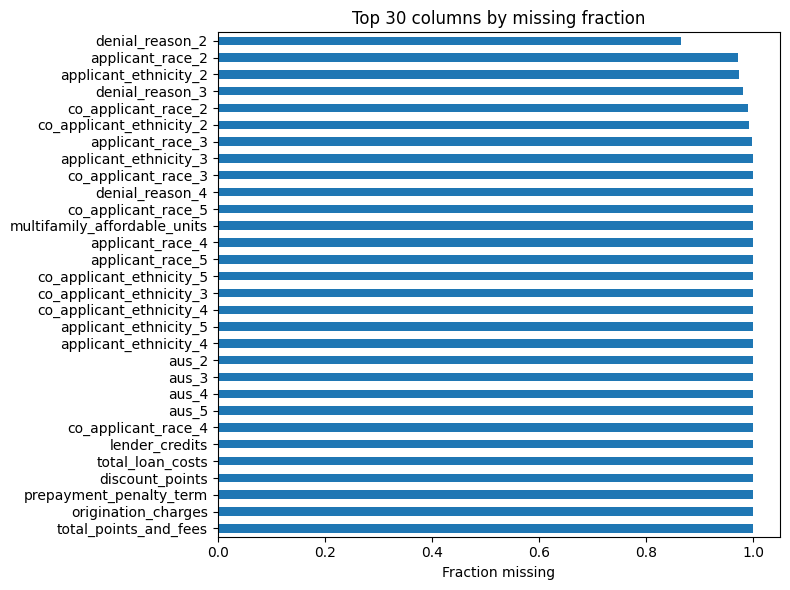

[eda_quick] Saved reports\EDA_missing_top30.png


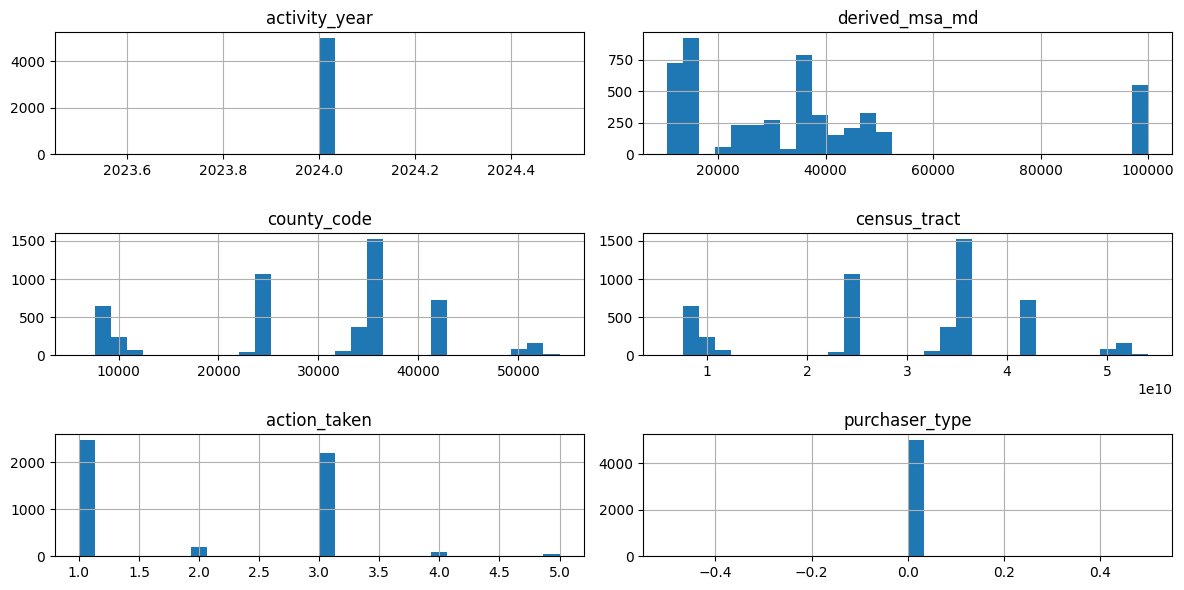

[eda_quick] Saved reports\EDA_numeric_sample_hist.png


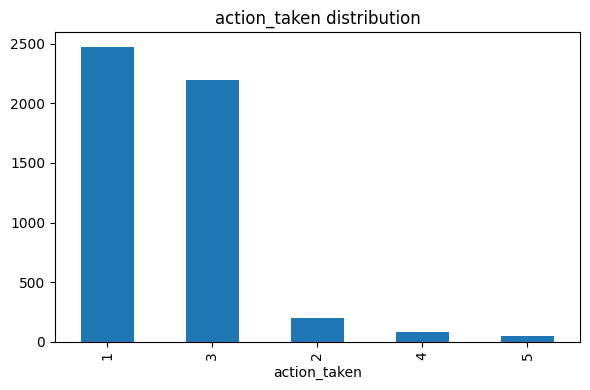

[eda_quick] Saved reports\EDA_action_taken_dist.png
Loaded schema.json: n_rows=5000, n_columns=99
Sample rows available at: artifacts\sample_rows.csv
Wrote requirements.txt
Wrote .gitignore


In [5]:
# %% [markdown]
# Day 1 — HMDA: Load, Describe & Quick EDA
#
# This Jupyter-ready Python file contains everything for *Day 1* packed into runnable cells.
# Open this file as a notebook (Jupyter / JupyterLab / VSCode) or run it as a script.
#
# Cells include:
# 1. Setup & imports
# 2. `load_and_describe` function (builds `artifacts/schema.json` and `artifacts/sample_rows.csv`)
# 3. Quick EDA helper and plotting
# 4. Run the Day 1 pipeline on `data/hmda.csv` (configurable)
# 5. Minimal pytest-style checks you can run interactively
#
# Save this file as `notebooks/Day1_load_and_schema.py` or open directly if your editor supports Jupytext.

# %%
# Setup & imports
from __future__ import annotations
import argparse
import json
import os
from collections import OrderedDict
from typing import Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: inline plotting if running in notebook
try:
    get_ipython()
    IN_JUPYTER = True
    %matplotlib inline
except Exception:
    IN_JUPYTER = False

SAMPLE_ROWS = 5
CATEGORICAL_UNIQUE_THRESHOLD = 50  # if unique values <= this, treat as categorical (heuristic)

# Ensure directories
os.makedirs("artifacts", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# %%
# Function: infer_column_info

def infer_column_info(series: pd.Series) -> Dict[str, Any]:
    non_null = series.dropna()
    dtype = str(series.dtype)
    n_unique = int(non_null.nunique()) if len(non_null) > 0 else 0
    # try to get representative sample values (convert numpy types to python)
    sample_vals = []
    for v in non_null.unique()[:SAMPLE_ROWS]:
        try:
            sample_vals.append(v.item() if hasattr(v, "item") else v)
        except Exception:
            sample_vals.append(v)
    # heuristic: numeric vs categorical vs text
    if pd.api.types.is_integer_dtype(series) or pd.api.types.is_float_dtype(series):
        role = "numeric"
    else:
        role = "categorical" if n_unique <= CATEGORICAL_UNIQUE_THRESHOLD else "text"
    return {"dtype": dtype, "n_unique": n_unique, "sample_values": sample_vals, "suggested_role": role}

# %%
# Function: load_and_describe

def load_and_describe(csv_path: str, out_path: str = "artifacts/schema.json", max_rows: int = None) -> Dict[str, Any]:
    """Load CSV and write a schema JSON + a small sample CSV for quick inspection.

    Returns the schema dict.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found at {csv_path}")
    print(f"[load_and_schema] Loading CSV: {csv_path}")
    df = pd.read_csv(csv_path, nrows=max_rows)
    print(f"[load_and_schema] Loaded {len(df)} rows and {len(df.columns)} columns.")

    schema: Dict[str, Any] = OrderedDict()
    schema["source_csv"] = os.path.abspath(csv_path)
    schema["n_rows"] = int(len(df))
    schema["n_columns"] = int(len(df.columns))
    schema["columns"] = OrderedDict()

    for col in df.columns:
        info = infer_column_info(df[col])
        schema["columns"][col] = info

    # derive simple recommended categorical lists for columns with small unique values
    schema["categorical_suggestions"] = {
        col: schema["columns"][col]["sample_values"]
        for col in schema["columns"]
        if schema["columns"][col]["suggested_role"] == "categorical"
    }

    # Save JSON and sample rows
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(schema, f, indent=2, ensure_ascii=False)

    sample_out = os.path.join(os.path.dirname(out_path), "sample_rows.csv")
    df.head(SAMPLE_ROWS).to_csv(sample_out, index=False)

    print(f"[load_and_schema] Wrote schema to {out_path}")
    print(f"[load_and_schema] Wrote sample rows to {sample_out}")

    # Basic assertions / warnings
    if len(df.columns) < 5:
        print("[load_and_schema] WARNING: CSV has less than 5 columns. Is this the correct file?")
    if len(df) < 50:
        print("[load_and_schema] WARNING: CSV has less than 50 rows. For ML you'll typically want more data.")

    return schema

# %% [markdown]
# Quick EDA helper
# This cell contains a simple function to produce a few plots and write them to `reports/`.

# %%
def quick_eda(csv_path: str, out_dir: str = "reports"):
    os.makedirs(out_dir, exist_ok=True)
    df = pd.read_csv(csv_path)
    print(f"[eda_quick] Loaded {len(df)} rows, {len(df.columns)} cols")

    # top missing columns
    missing = df.isna().mean().sort_values(ascending=False)
    top_missing = missing.head(30)
    plt.figure(figsize=(8,6))
    top_missing.plot.barh()
    plt.xlabel("Fraction missing")
    plt.title("Top 30 columns by missing fraction")
    plt.tight_layout()
    p1 = os.path.join(out_dir, "EDA_missing_top30.png")
    plt.savefig(p1)
    plt.show()
    plt.close()
    print(f"[eda_quick] Saved {p1}")

    # numeric histograms (sample up to 6)
    nums = df.select_dtypes(include=["int64","float64"]).columns.tolist()
    if len(nums) > 0:
        sample_nums = nums[:6]
        df[sample_nums].hist(figsize=(12,6), bins=30)
        p2 = os.path.join(out_dir, "EDA_numeric_sample_hist.png")
        plt.tight_layout()
        plt.savefig(p2)
        plt.show()
        plt.close()
        print(f"[eda_quick] Saved {p2}")
    else:
        print("[eda_quick] No numeric columns found for histograms")

    # target distribution if action_taken exists
    if "action_taken" in df.columns:
        plt.figure(figsize=(6,4))
        df["action_taken"].value_counts().plot.bar()
        plt.title("action_taken distribution")
        p3 = os.path.join(out_dir, "EDA_action_taken_dist.png")
        plt.tight_layout()
        plt.savefig(p3)
        plt.show()
        plt.close()
        print(f"[eda_quick] Saved {p3}")
    else:
        print("[eda_quick] No 'action_taken' column found; skipping target plot")

# %% [markdown]
# Run Day 1 pipeline: build schema + quick EDA
#
# Adjust the csv_path variable below if your HMDA file is elsewhere.

# %%
# User config: path to CSV
csv_path = r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibility Predictor\hmda_sample_preview.csv"
  # change this if your csv is elsewhere
schema_out = "artifacts/schema.json"

# If running interactively, we can run the pipeline now (comment/uncomment as needed)
if os.path.exists(csv_path):
    schema = load_and_describe(csv_path, schema_out)
    print("Schema keys:", list(schema.keys()))
    # run quick eda
    quick_eda(csv_path, out_dir="reports")
else:
    print(f"CSV not found at {csv_path}. Place your HMDA CSV there or edit the csv_path variable.")

# %% [markdown]
# Minimal interactive checks (pytest-style) — run these cells after the pipeline ran

# %%
# Check: artifacts/schema.json exists and looks sane
if os.path.exists(schema_out):
    with open(schema_out, "r", encoding="utf-8") as f:
        s = json.load(f)
    print(f"Loaded schema.json: n_rows={s.get('n_rows')}, n_columns={s.get('n_columns')}")
    sample = os.path.join(os.path.dirname(schema_out), "sample_rows.csv")
    if os.path.exists(sample):
        print("Sample rows available at:", sample)
else:
    print("schema.json not found — run the pipeline cell above.")

# %% [markdown]
# Save requirements and .gitignore (optional helper cells). Run to write files.

# %%
req_text = '''pandas>=1.3
numpy>=1.21
matplotlib>=3.4
pytest>=6.0
seaborn>=0.11
jupyterlab
'''

gitignore_text = '''# artifacts and models
artifacts/
models/
reports/
__pycache__/
.env
.env.*
*.pyc
.ipynb_checkpoints/
'''

with open("requirements.txt", "w", encoding="utf-8") as f:
    f.write(req_text)
print("Wrote requirements.txt")

with open(".gitignore", "w", encoding="utf-8") as f:
    f.write(gitignore_text)
print("Wrote .gitignore")

# %% [markdown]
# End of Day 1 notebook
# You can now run the tests (from shell):
#   pytest -q
# or run the interactive checks above.
#
# Next: Day 2 cleaning script scaffolding can be generated when you're ready.


In [7]:
# %% [markdown]
# Day 2 — HMDA Cleaning & Canonicalization
# Produces: artifacts/cleaned.csv
# Also writes tests in tests/test_cleaning.py (run with pytest)
#
# Rules applied (conservative defaults):
# - Drop columns with > 95% missing values
# - For numeric columns: impute median
# - For categorical/text columns: fill with '__MISSING__'
# - Treat specific sentinel values (e.g., '9999' in age, 'NA' strings) as missing
# - Standardize some HMDA fields (applicant_age, debt_to_income_ratio)
# - Save a cleaning log: artifacts/cleaning_log.json
#
# Adjust thresholds or column lists as you like.
# %%


# %% [markdown]
# 1) Setup & imports
# %%
from __future__ import annotations
import json
import os
from typing import Dict, Any, List

import numpy as np
import pandas as pd

# nice display when running in notebook
try:
    get_ipython()
    %matplotlib inline
except Exception:
    pass

os.makedirs("artifacts", exist_ok=True)
os.makedirs("reports", exist_ok=True)
os.makedirs("tests", exist_ok=True)

SCHEMA_PATH = "artifacts/schema.json"
RAW_FALLBACK =  r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibility Predictor\hmda_sample_preview.csv"  # your uploaded file path
CLEANED_OUT = "artifacts/cleaned.csv"
CLEAN_LOG = "artifacts/cleaning_log.json"

# %% [markdown]
# 2) Load schema.json (produced in Day 1)
# %%
if not os.path.exists(SCHEMA_PATH):
    raise FileNotFoundError(f"schema.json not found at {SCHEMA_PATH}. Run Day 1 first.")

with open(SCHEMA_PATH, "r", encoding="utf-8") as f:
    schema = json.load(f)

print(f"[Day2] schema loaded: {schema.get('n_rows')} rows × {schema.get('n_columns')} cols")

# %% [markdown]
# 3) Load raw CSV (prefer artifacts/cleaned.csv if already present, else raw data)
# %%
csv_candidates = ["artifacts/cleaned.csv", "data/hmda.csv", RAW_FALLBACK]
csv_path = None
for p in csv_candidates:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("No input CSV found. Put your HMDA csv at data/hmda.csv or use the uploaded path.")

print(f"[Day2] Loading CSV from: {csv_path}")
df = pd.read_csv(csv_path)
orig_n = len(df)
print(f"[Day2] Raw DF shape: {df.shape}")

# %% [markdown]
# 4) Conservative cleaning heuristics
# - Drop cols with > MISSING_THRESH fraction missing
# - Convert certain sentinel values to NaN
# - Impute numerics with median; categorical with '__MISSING__'
# - Standardize a few important fields
# %%
MISSING_THRESH = 0.95  # drop columns with >95% missing (conservative)
drop_cols = []
for col in df.columns:
    miss_frac = df[col].isna().mean()
    if miss_frac > MISSING_THRESH:
        drop_cols.append(col)

print(f"[Day2] Dropping {len(drop_cols)} columns with >{MISSING_THRESH*100:.0f}% missing (examples): {drop_cols[:10]}")
df = df.drop(columns=drop_cols)

# Convert string '9999' or '999999' or 'NA' in age-like or code columns to NaN
SENTINELS = ["9999", "99999", "999999", "NA", "na", "N/A", "n/a", ""]
def replace_sentinels(x):
    if pd.isna(x):
        return x
    if isinstance(x, str) and x.strip() in SENTINELS:
        return np.nan
    return x

# Apply to common columns (if present)
for c in ["applicant_age", "co_applicant_age", "debt_to_income_ratio"]:
    if c in df.columns:
        df[c] = df[c].apply(replace_sentinels)

# If there are numeric-looking columns stored as object, coerce them
# We'll attempt to coerce numeric columns listed in schema as 'numeric' or int/float dtypes
numeric_candidates = []
for col, info in schema["columns"].items():
    if col in df.columns:
        # treat dtype 'int64' or 'float64' or suggested_role 'numeric' as numeric
        if info.get("suggested_role") == "numeric" or info.get("dtype") in ("int64", "float64"):
            numeric_candidates.append(col)
# coerce safely
for c in numeric_candidates:
    try:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    except Exception:
        pass

# Standardize debt_to_income_ratio: some rows show strings like '50%-60%' or '42'
if "debt_to_income_ratio" in df.columns:
    def parse_dti(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, str) and "-" in x:
            # take the midpoint of '20%-<30%' or '50%-60%'
            # strip non-digits and compute approximate midpoint
            import re
            nums = re.findall(r"\d+", x)
            if len(nums) >= 2:
                lo = float(nums[0]); hi = float(nums[1])
                return (lo + hi) / 2.0
            elif len(nums) == 1:
                return float(nums[0])
            else:
                return np.nan
        # if numeric string
        try:
            return float(x)
        except Exception:
            return np.nan
    df["debt_to_income_ratio_parsed"] = df["debt_to_income_ratio"].apply(parse_dti) if "debt_to_income_ratio" in df.columns else None

# Standardize applicant_age (map ranges to median year of age-group)
if "applicant_age" in df.columns:
    AGE_MAP = {
        "25-34": 30, "35-44": 40, "45-54": 50, "55-64": 60, "65-74": 70, ">74": 80,
        "18-24": 21, "75+": 80, "Under 18": 17,
    }
    def age_to_num(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, str):
            if x in AGE_MAP:
                return AGE_MAP[x]
            # sometimes encoded as numbers 1/2... keep if numeric
            try:
                return float(x)
            except:
                return np.nan
        try:
            return float(x)
        except:
            return np.nan
    df["applicant_age_num"] = df["applicant_age"].apply(age_to_num) if "applicant_age" in df.columns else None

# Create a few flags: rate_spread_missing_flag
if "rate_spread" in df.columns:
    df["rate_spread_missing_flag"] = df["rate_spread"].isna().astype(int)

# For HMDA 'action_taken' we will keep as-is, but also create binary target 'approved_flag' where 1 if action in {1,2}
if "action_taken" in df.columns:
    df["approved_flag"] = df["action_taken"].apply(lambda v: 1 if int(v) in (1,2) else 0)

# %% [markdown]
# 5) Imputation & final column selection
# - Impute numeric columns with median (except those flagged intentionally)
# - Fill categorical/text with '__MISSING__'
# - Keep the columns we want for modeling (we'll keep a conservative subset + all retained columns)
# %%
# Imputation for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# We will not impute these columns that we want to keep NaN for special handling only if you want:
special_keep_na = []  # example: ["rate_spread"]  # but we already created missing flag
impute_medians = {}
for c in numeric_cols:
    if c in special_keep_na:
        continue
    med = float(df[c].median(skipna=True)) if df[c].notna().any() else 0.0
    impute_medians[c] = med
    df[c] = df[c].fillna(med)

# Categorical fill
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna("__MISSING__").astype(str)

# For parsed columns we created, ensure types
if "debt_to_income_ratio_parsed" in df.columns:
    df["debt_to_income_ratio_parsed"] = df["debt_to_income_ratio_parsed"].astype(float).fillna(0.0)

if "applicant_age_num" in df.columns:
    df["applicant_age_num"] = df["applicant_age_num"].astype(float).fillna(0.0)

# Save a canonical cleaned dataframe (keep all columns that survived)
df_cleaned = df.copy()
df_cleaned.to_csv(CLEANED_OUT, index=False)
print(f"[Day2] Saved cleaned CSV to {CLEANED_OUT} with shape {df_cleaned.shape}")

# Save cleaning log (columns dropped, medians used)
cleaning_log = {
    "orig_n_rows": orig_n,
    "final_n_rows": len(df_cleaned),
    "orig_n_cols": int(schema.get("n_columns", 0)),
    "final_n_cols": df_cleaned.shape[1],
    "dropped_columns": drop_cols,
    "impute_medians": impute_medians,
}
with open(CLEAN_LOG, "w", encoding="utf-8") as f:
    json.dump(cleaning_log, f, indent=2)
print(f"[Day2] Wrote cleaning log to {CLEAN_LOG}")

# %% [markdown]
# 6) Minimal interactive checks (you can run these cells manually)
# %%
# a) No column with > 95% missing
missing_fracs = df_cleaned.isna().mean().sort_values(ascending=False)
print("[Day2] Top 10 columns by missing fraction after cleaning:")
print(missing_fracs.head(10))

# b) Ensure no duplicated rows (if index not meaningful, check for exact duplicates)
dupes = df_cleaned.duplicated().sum()
print(f"[Day2] Exact duplicate rows after cleaning: {dupes}")

# c) Sanity: required numeric columns exist (loan_amount, income, rate_spread may exist)
required_numeric = ["loan_amount", "income", "applicant_age_num"]
present_required = [c for c in required_numeric if c in df_cleaned.columns]
print("[Day2] Required numeric columns present:", present_required)

# %% [markdown]
# 7) Write pytest unit test file to tests/test_cleaning.py
# %%
test_code = r'''
import os
import pandas as pd
import json
import pytest
CLEAN_PATH = "artifacts/cleaned.csv"
LOG_PATH = "artifacts/cleaning_log.json"

def test_cleaned_exists():
    assert os.path.exists(CLEAN_PATH), "artifacts/cleaned.csv not found. Run cleaning pipeline."

def test_no_high_missing_cols():
    df = pd.read_csv(CLEAN_PATH)
    miss = df.isna().mean()
    # No column should have > 95% missing after cleaning
    assert (miss <= 0.95).all(), "Some columns still have >95% missing."

def test_cleaning_log():
    assert os.path.exists(LOG_PATH)
    with open(LOG_PATH, "r", encoding="utf-8") as f:
        log = json.load(f)
    assert "dropped_columns" in log and "impute_medians" in log

def test_no_exact_duplicates():
    df = pd.read_csv(CLEAN_PATH)
    assert df.duplicated().sum() == 0, "Exact duplicate rows present in cleaned.csv"
'''
with open("tests/test_cleaning.py", "w", encoding="utf-8") as f:
    f.write(test_code)
print("[Day2] Wrote tests/test_cleaning.py (run pytest -q)")

# %% [markdown]
# Done — Day 2 cleaning complete.
# Next steps:
# - Review artifacts/cleaned.csv and artifacts/cleaning_log.json
# - If you're happy, proceed to Day 3: feature engineering (I can scaffold the canonical 24 features using your cleaned data)
# - Run tests:
#     pip install -r requirements.txt
#     pytest -q
# %%


[Day2] schema loaded: 5000 rows × 99 cols
[Day2] Loading CSV from: C:\Users\meghr\OneDrive\Desktop\Loan Eligibility Predictor\hmda_sample_preview.csv
[Day2] Raw DF shape: (5000, 99)
[Day2] Dropping 29 columns with >95% missing (examples): ['total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'prepayment_penalty_term', 'multifamily_affordable_units', 'applicant_ethnicity_2', 'applicant_ethnicity_3', 'applicant_ethnicity_4']
[Day2] Saved cleaned CSV to artifacts/cleaned.csv with shape (5000, 74)
[Day2] Wrote cleaning log to artifacts/cleaning_log.json
[Day2] Top 10 columns by missing fraction after cleaning:
activity_year                0.0
lei                          0.0
derived_msa_md               0.0
state_code                   0.0
county_code                  0.0
census_tract                 0.0
conforming_loan_limit        0.0
derived_loan_product_type    0.0
derived_dwelling_category    0.0
derived_ethnicity            0.0
dtyp

In [8]:
import pandas as pd
path = "artifacts/cleaned.csv"
df = pd.read_csv(path)

# show duplicates (first few) and how many
dupes_mask = df.duplicated(keep=False)
print("Total duplicates (keep=False):", dupes_mask.sum())
print(df[dupes_mask].head(10))

# if you want to drop exact duplicate rows and save:
df_dedup = df.drop_duplicates(keep="first").reset_index(drop=True)
print("After drop duplicates shape:", df_dedup.shape)
df_dedup.to_csv(path, index=False)

# update cleaning log quickly
import json
log = {}
with open("artifacts/cleaning_log.json","r",encoding="utf-8") as f:
    log = json.load(f)
log["duplicates_removed"] = True
log["final_n_rows_after_dedup"] = int(df_dedup.shape[0])
with open("artifacts/cleaning_log.json","w",encoding="utf-8") as f:
    json.dump(log, f, indent=2)
print("Saved deduped CSV and updated cleaning_log.json")


Total duplicates (keep=False): 2
      activity_year                   lei  derived_msa_md state_code  \
3778           2024  WWB2V0FCW3A0EE3ZJN75           35004         NY   
3877           2024  WWB2V0FCW3A0EE3ZJN75           35004         NY   

      county_code  census_tract conforming_loan_limit  \
3778        36059   36059413500                     C   
3877        36059   36059413500                     C   

          derived_loan_product_type             derived_dwelling_category  \
3778  Conventional:Subordinate Lien  Single Family (1-4 Units):Site-Built   
3877  Conventional:Subordinate Lien  Single Family (1-4 Units):Site-Built   

           derived_ethnicity  ... tract_minority_population_percent  \
3778  Not Hispanic or Latino  ...                             74.26   
3877  Not Hispanic or Latino  ...                             74.26   

     ffiec_msa_md_median_family_income  tract_to_msa_income_percentage  \
3778                            156200                    

In [26]:
#!/usr/bin/env python3
"""
Day 2.5: Prepare strict Approved vs Denied dataset for HMDA experiments.

- Loads artifacts/cleaned.csv
- Keeps only action_taken in {1, 3} (1 = originated/approved, 3 = denied)
- Writes artifacts/cleaned_strict.csv (safe subset)
- Recomputes approved_flag (1 if action_taken == 1 else 0)
- Drops duplicates and rows missing essential fields
- Optionally calls the safe feature builder to produce X.npy/y.npy (toggle CALL_FEATURE_BUILDER)
- Writes a small audit log at artifacts/cleaned_strict_log.json

Usage:
    python scripts/prep_strict_dataset.py
or in Jupyter:
    %run scripts/prep_strict_dataset.py
"""

from __future__ import annotations
import os, json, sys
from pathlib import Path
import pandas as pd
import numpy as np

ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True)

INPUT_CSV = ARTIFACTS / "cleaned.csv"
OUTPUT_CSV = ARTIFACTS / "cleaned_strict.csv"
LOG_PATH = ARTIFACTS / "cleaned_strict_log.json"

# If you want this script to automatically run the safe Day 3 builder after filtering,
# set CALL_FEATURE_BUILDER = True and ensure src/features/build_features_safe.py exists.
CALL_FEATURE_BUILDER = True
FEATURE_BUILDER_SCRIPT = "src/features/build_features_safe.py"

# The HMDA action_taken codes we keep:
# 1 -> originated/approved (keep as positive)
# 3 -> denied (negative)
KEEP_ACTION_TAKEN = {1, 3}

ESSENTIAL_COLUMNS = ["action_taken", "approved_flag"]  # ensure target present

def main():
    if not INPUT_CSV.exists():
        print(f"[ERROR] Input cleaned CSV not found at {INPUT_CSV}. Run Day 2 cleaning first.", file=sys.stderr)
        sys.exit(2)

    df = pd.read_csv(INPUT_CSV)
    n_in = len(df)
    cols_in = list(df.columns)

    # normalize action_taken to numeric if needed
    if "action_taken" in df.columns:
        try:
            df["action_taken"] = pd.to_numeric(df["action_taken"], errors="coerce").astype(pd.Int64Dtype())
        except Exception:
            # fallback: cast via int for values that look numeric
            df["action_taken"] = df["action_taken"].astype(str).str.extract(r"(\d+)").astype(float).astype(pd.Int64Dtype())

    # Filter to action_taken in KEEP_ACTION_TAKEN
    before_filter = len(df)
    df_strict = df[df["action_taken"].isin(list(KEEP_ACTION_TAKEN))].copy()
    after_filter = len(df_strict)

    # If approved_flag not present or inconsistent, recompute it
    if "approved_flag" not in df_strict.columns:
        df_strict["approved_flag"] = (df_strict["action_taken"] == 1).astype(int)
    else:
        # enforce approved_flag consistency: 1 if action_taken==1 else 0
        df_strict["approved_flag"] = (df_strict["action_taken"] == 1).astype(int)

    # Drop rows with missing approved_flag or action_taken
    missing_target_before = df_strict["approved_flag"].isna().sum()
    df_strict = df_strict.dropna(subset=["approved_flag", "action_taken"])
    missing_target_after = df_strict["approved_flag"].isna().sum()

    # Drop exact duplicates
    n_dup_before = df_strict.duplicated(keep=False).sum()
    df_strict = df_strict.drop_duplicates()
    n_dup_after = df_strict.duplicated(keep=False).sum()

    # Optional: drop rows missing essential application-time columns (loan_amount or income)
    required_for_model = ["loan_amount", "income"]
    missing_req = {}
    for c in required_for_model:
        if c in df_strict.columns:
            missing_req[c] = int(df_strict[c].isna().sum())
        else:
            missing_req[c] = None

    # Save output
    df_strict.to_csv(OUTPUT_CSV, index=False)

    # Log summary
    log = {
        "input_file": str(INPUT_CSV),
        "n_rows_in": int(n_in),
        "n_rows_after_action_filter": int(after_filter),
        "action_taken_kept": sorted(list(KEEP_ACTION_TAKEN)),
        "missing_target_before_drop": int(missing_target_before),
        "missing_target_after_drop": int(missing_target_after),
        "num_duplicates_before": int(n_dup_before),
        "num_duplicates_after": int(n_dup_after),
        "required_field_missing_counts": missing_req,
        "columns_in_input": cols_in,
        "columns_in_output": list(df_strict.columns),
    }
    with open(LOG_PATH, "w", encoding="utf-8") as f:
        json.dump(log, f, indent=2)
    print(f"[OK] Wrote filtered strict CSV to {OUTPUT_CSV}")
    print(f"[OK] Wrote audit log to {LOG_PATH}")

    # Optionally call safe feature builder
    if CALL_FEATURE_BUILDER:
        builder_path = Path(FEATURE_BUILDER_SCRIPT)
        if builder_path.exists():
            print("[INFO] Running safe feature builder to regenerate X.npy/y.npy for strict dataset...")
            # run builder via subprocess to avoid Jupyter argv issues
            import subprocess, shlex
            cmd = f"{sys.executable} {shlex.quote(str(builder_path))} --csv {shlex.quote(str(OUTPUT_CSV))}"
            print(f"[INFO] Running: {cmd}")
            proc = subprocess.run(cmd, shell=True)
            if proc.returncode != 0:
                print("[WARN] Feature builder returned non-zero exit code. Please run it manually.", file=sys.stderr)
            else:
                print("[OK] Feature builder completed.")
        else:
            print(f"[WARN] Feature builder script not found at {builder_path}. Skipping automatic feature build.")

if __name__ == "__main__":
    main()


[OK] Wrote filtered strict CSV to artifacts\cleaned_strict.csv
[OK] Wrote audit log to artifacts\cleaned_strict_log.json
[WARN] Feature builder script not found at src\features\build_features_safe.py. Skipping automatic feature build.


In [27]:
#!/usr/bin/env python3
"""
Day 3 (SAFE) feature builder for HMDA cleaned data.

Saves:
  artifacts/feature_list.txt
  artifacts/encodings.json
  artifacts/X.npy
  artifacts/y.npy
  artifacts/features_preview.csv
  artifacts/feature_build_log.json

Usage:
  python src/features/build_features_safe.py --csv artifacts/cleaned.csv
Or in Jupyter:
  %run src/features/build_features_safe.py --csv artifacts/cleaned.csv
"""

from __future__ import annotations
import argparse
import json
import os
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd

# --- Config / safe canonical list ---
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

SAFE_CANONICAL = [
    "loan_amount",
    "income",
    "income_to_loan_ratio",
    "applicant_age_num",
    "applicant_race_1_enc",
    "applicant_sex_enc",
    "applicant_ethnicity_enc",
    "derived_race_enc",
    "derived_ethnicity_enc",
    "derived_sex_enc",
    "loan_type_enc",
    "loan_purpose_enc",
    "occupancy_type_enc",
    "property_type_enc",
    "state_code_enc",
    "county_code_enc",
    "derived_msa_md_enc",
    "tract_minority_population_percent",
    "approved_flag"
]

# Map canonical enc names to candidate source columns in cleaned.csv
CAT_MAP = {
    "applicant_race_1_enc": ["applicant_race_1"],
    "applicant_sex_enc": ["applicant_sex"],
    "applicant_ethnicity_enc": ["applicant_ethnicity"],
    "derived_race_enc": ["derived_race"],
    "derived_ethnicity_enc": ["derived_ethnicity"],
    "derived_sex_enc": ["derived_sex"],
    "loan_type_enc": ["loan_type"],
    "loan_purpose_enc": ["loan_purpose"],
    "occupancy_type_enc": ["occupancy_type"],
    "property_type_enc": ["property_type"],
    "state_code_enc": ["state_code"],
    "county_code_enc": ["county_code"],
    "derived_msa_md_enc": ["derived_msa_md"],
}

# --- Helpers ---
def freq_encode_series(s: pd.Series) -> Tuple[pd.Series, Dict[str, float]]:
    """Turn a categorical Series into frequency-encoded numeric series and return the mapping."""
    ser = s.fillna("__MISSING__").astype(str)
    freqs = ser.value_counts(normalize=True).to_dict()
    enc = ser.map(lambda v: freqs.get(v, 0.0)).astype(float)
    return enc, {str(k): float(v) for k, v in freqs.items()}

def write_feature_list(path: Path = ARTIFACT_DIR / "feature_list.txt"):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for feat in SAFE_CANONICAL:
            f.write(feat + "\n")

# --- Core builder ---
def build_features_from_df(df: pd.DataFrame, save_encodings: bool = True) -> Tuple[pd.DataFrame, pd.Series, Dict[str, Dict[str, float]]]:
    """Return X_df (predictors), y_ser (target), encodings dict."""
    n = len(df)
    encodings: Dict[str, Dict[str, float]] = {}

    # numeric fields (robust conversion)
    def get_numeric(col, default=0.0):
        if col in df.columns:
            return pd.to_numeric(df[col], errors="coerce").fillna(default).astype(float)
        else:
            return pd.Series([default] * n, dtype=float)

    loan_amount = get_numeric("loan_amount", 0.0)
    income = get_numeric("income", 0.0)
    applicant_age_num = get_numeric("applicant_age_num", 0.0)
    tract_minority_population_percent = get_numeric("tract_minority_population_percent", 0.0)

    # derive income_to_loan_ratio robustly (handle income recorded in thousands)
    income_vals = income.copy()
    if income_vals.median() < 1000:
        income_abs = income_vals * 1000.0
    else:
        income_abs = income_vals
    with np.errstate(divide="ignore", invalid="ignore"):
        income_to_loan_ratio = (income_abs / loan_amount.replace({0: np.nan})).fillna(0.0).astype(float)

    features: Dict[str, pd.Series] = {
        "loan_amount": loan_amount,
        "income": income,
        "income_to_loan_ratio": income_to_loan_ratio,
        "applicant_age_num": applicant_age_num,
        "tract_minority_population_percent": tract_minority_population_percent
    }

    # categorical encodings (frequency)
    for feat_name, candidates in CAT_MAP.items():
        found = None
        for cand in candidates:
            if cand in df.columns:
                found = cand
                break
        if found is None:
            ser = pd.Series(["__MISSING__"] * n)
        else:
            ser = df[found].fillna("__MISSING__").astype(str)
        enc_series, freqs = freq_encode_series(ser)
        features[feat_name] = enc_series
        encodings[feat_name] = freqs

    # Assemble X using SAFE_CANONICAL minus target
    X_cols = [c for c in SAFE_CANONICAL if c != "approved_flag"]
    X_df = pd.DataFrame({c: features.get(c, pd.Series([0.0] * n)) for c in X_cols}).astype(float)

    # target
    y_ser = None
    if "approved_flag" in df.columns:
        y_ser = pd.to_numeric(df["approved_flag"], errors="coerce").fillna(0).astype(int)

    # Save encodings
    if save_encodings:
        enc_path = ARTIFACT_DIR / "encodings.json"
        with enc_path.open("w", encoding="utf-8") as f:
            json.dump(encodings, f, indent=2, ensure_ascii=False)

    return X_df, y_ser, encodings

# --- Main CLI / Jupyter friendly entry ---
def main(argv=None):
    parser = argparse.ArgumentParser()
    parser.add_argument("--csv", type=str, default=str(ARTIFACT_DIR / "cleaned.csv"), help="Input cleaned CSV path")
    parser.add_argument("--out-x", type=str, default=str(ARTIFACT_DIR / "X.npy"), help="Output X.npy path")
    parser.add_argument("--out-y", type=str, default=str(ARTIFACT_DIR / "y.npy"), help="Output y.npy path")
    args = parser.parse_args(argv)

    in_csv = Path(args.csv)
    if not in_csv.exists():
        raise FileNotFoundError(f"Cleaned CSV not found at {in_csv}. Run Day 2 cleaning first.")

    df = pd.read_csv(in_csv)
    print(f"[SAFE build] loaded {in_csv} with shape {df.shape}")

    # write canonical feature list (overwrite)
    write_feature_list()
    print(f"[SAFE build] wrote feature list to {ARTIFACT_DIR/'feature_list.txt'}")

    # build features
    X_df, y_ser, enc = build_features_from_df(df, save_encodings=True)

    # Validate
    expected_len = len(SAFE_CANONICAL) - 1
    if X_df.shape[1] != expected_len:
        raise ValueError(f"[SAFE build] produced {X_df.shape[1]} features but expected {expected_len}; check CANONICAL mapping")

    # save outputs
    np.save(args.out_x, X_df.values)
    print(f"[SAFE build] saved X.npy at {args.out_x} shape={X_df.values.shape}")
    if y_ser is not None:
        np.save(args.out_y, y_ser.values)
        print(f"[SAFE build] saved y.npy at {args.out_y} shape={y_ser.values.shape}")

    preview_path = ARTIFACT_DIR / "features_preview.csv"
    X_df.head(200).to_csv(preview_path, index=False)
    print(f"[SAFE build] wrote preview to {preview_path}")

    # build log
    build_log = {
        "input_csv": str(in_csv),
        "n_rows_in": int(len(df)),
        "n_columns_in": int(df.shape[1]),
        "n_features_out": int(X_df.shape[1]),
        "feature_list": SAFE_CANONICAL,
    }
    with (ARTIFACT_DIR / "feature_build_log.json").open("w", encoding="utf-8") as f:
        json.dump(build_log, f, indent=2)
    print(f"[SAFE build] wrote feature_build_log.json")

if __name__ == "__main__":
    # filter Jupyter hidden args automatically
    import sys
    argv = [a for a in sys.argv[1:] if not a.startswith("--f=")]
    main(argv)


[SAFE build] loaded artifacts\cleaned.csv with shape (4999, 74)
[SAFE build] wrote feature list to artifacts\feature_list.txt
[SAFE build] saved X.npy at artifacts\X.npy shape=(4999, 18)
[SAFE build] saved y.npy at artifacts\y.npy shape=(4999,)
[SAFE build] wrote preview to artifacts\features_preview.csv
[SAFE build] wrote feature_build_log.json


In [28]:
import os
import numpy as np
def test_feature_list_and_X():
    assert os.path.exists("artifacts/feature_list.txt")
    feats = [l.strip() for l in open("artifacts/feature_list.txt").read().splitlines() if l.strip()]
    X_path = "artifacts/X.npy"
    assert os.path.exists(X_path)
    X = np.load(X_path)
    # expected features = len(feature_list)-1
    assert X.ndim == 2
    assert X.shape[1] == len(feats) - 1


[I 2025-09-07 11:35:23,395] A new study created in memory with name: no-name-3cbb11cb-7a00-4392-95a3-c32d1a2037ac


[Day4] Loaded X shape (4999, 18), y shape (4999,)
[Day4] Train/test split: (4249, 18) / (750, 18)
[Day4] pos=2272, neg=1977, scale_pos_weight=0.870
[Day4] Training Logistic Regression...
[Day4] LR done.
[Day4] Tuning/Training RandomForest...


[I 2025-09-07 11:35:25,489] Trial 0 finished with value: 0.7578968294217673 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.7578968294217673.
[I 2025-09-07 11:35:27,064] Trial 1 finished with value: 0.7322851703031269 and parameters: {'n_estimators': 383, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.7578968294217673.
[I 2025-09-07 11:35:33,352] Trial 2 finished with value: 0.7559828464175556 and parameters: {'n_estimators': 273, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.7578968294217673.
[I 2025-09-07 11:35:40,337] Trial 3 finished with value: 0.7516207599264545 and parameters: {'n_estimators': 306, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_featur

[Day4] RF done.
[Day4] Tuning/Training XGBoost...


[I 2025-09-07 11:37:07,665] Trial 0 finished with value: 0.7517664456573191 and parameters: {'n_estimators': 218, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 0.7517664456573191.
[I 2025-09-07 11:37:09,746] Trial 1 finished with value: 0.7566720812838156 and parameters: {'n_estimators': 321, 'max_depth': 10, 'learning_rate': 0.010725209743171996, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.9091248360355031, 'reg_lambda': 0.9170225492671691}. Best is trial 1 with value: 0.7566720812838156.
[I 2025-09-07 11:37:10,654] Trial 2 finished with value: 0.7615339665865437 and parameters: {'n_estimators': 187, 'max_depth': 8, 'learning_rate': 0.04345454109729477, 'subsample': 0.645614570099021, 'colsample_bytree': 0.80592

[Day4] XGBoost done.
[Day4] Tuning/Training HistGradientBoosting...


[I 2025-09-07 11:37:31,456] Trial 0 finished with value: 0.7210008073751091 and parameters: {'max_iter': 181, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.7210008073751091.
[I 2025-09-07 11:37:31,708] Trial 1 finished with value: 0.7560369002947356 and parameters: {'max_iter': 104, 'learning_rate': 0.01699897838270077, 'max_depth': 3, 'min_samples_leaf': 44}. Best is trial 1 with value: 0.7560369002947356.
[I 2025-09-07 11:37:32,158] Trial 2 finished with value: 0.7604283283546502 and parameters: {'max_iter': 260, 'learning_rate': 0.11114989443094977, 'max_depth': 3, 'min_samples_leaf': 49}. Best is trial 2 with value: 0.7604283283546502.
[I 2025-09-07 11:37:33,068] Trial 3 finished with value: 0.7700375222296841 and parameters: {'max_iter': 342, 'learning_rate': 0.020589728197687916, 'max_depth': 4, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.7700375222296841.
[I 2025-09-07 11:37:33,949] Trial 4 finished with v

[Day4] HGB done.
[Day4] Saved model comparison report.


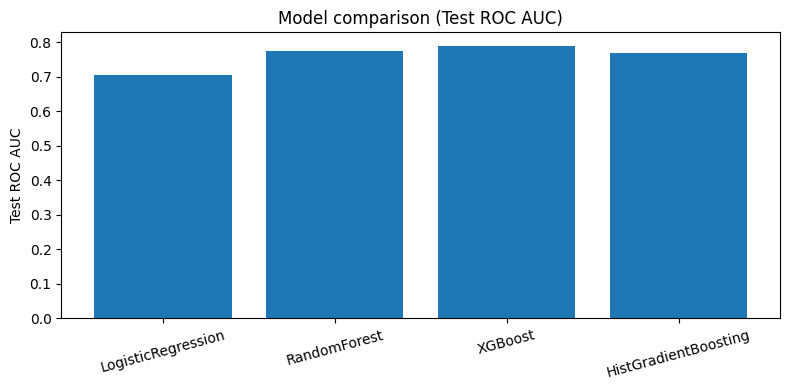

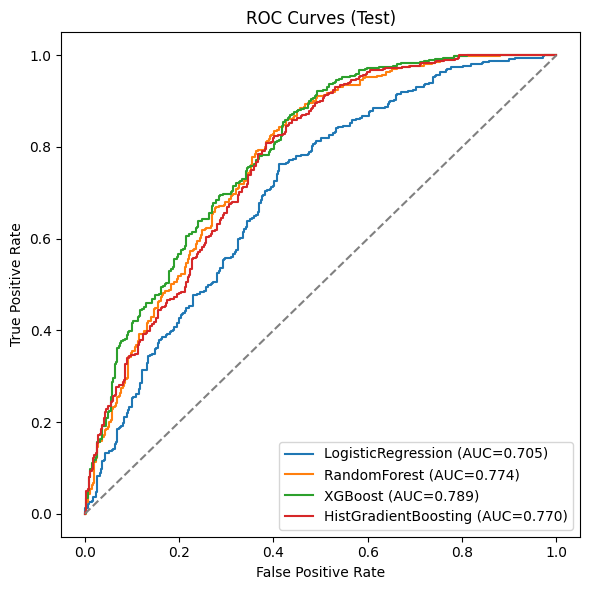

[Day4] Best by ROC AUC (with priority): XGBoost


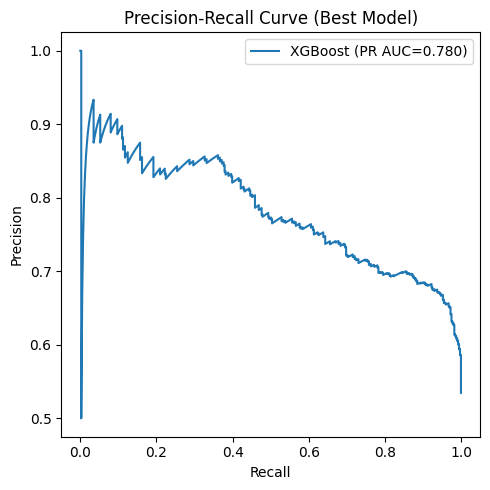

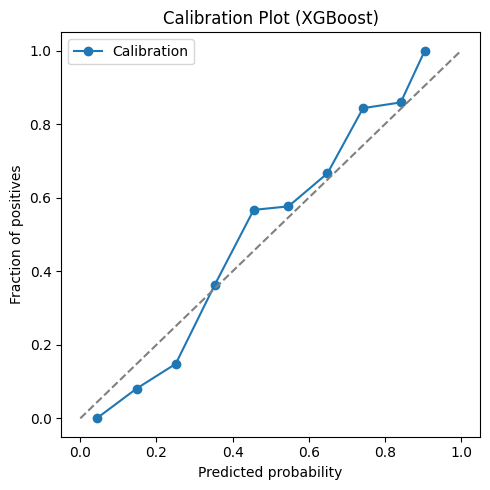

[Day4] Calibrated test ROC AUC: 0.7881371070890111


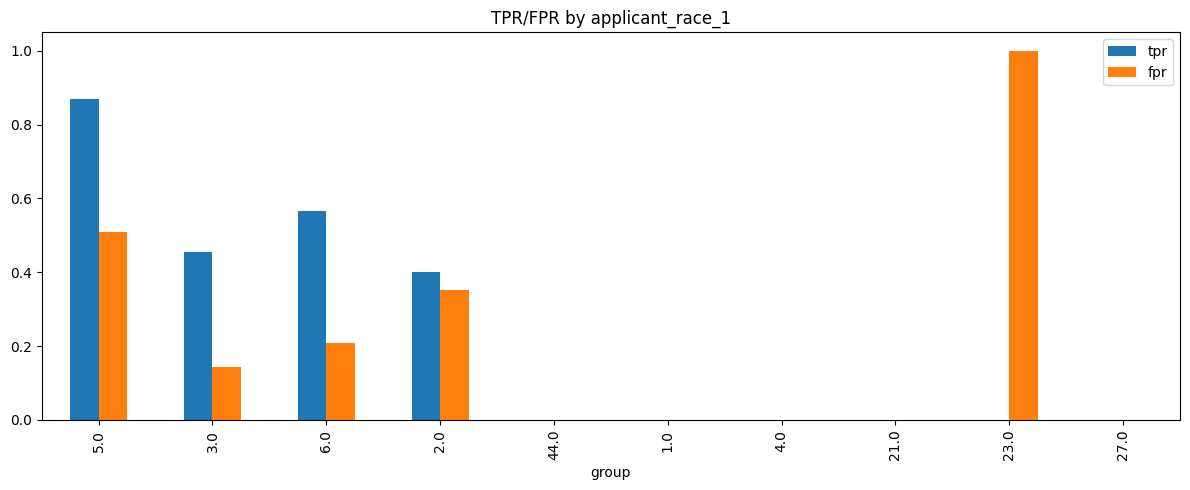

[Day4] Saved group TPR/FPR plot for applicant_race_1
[Day4] Saved model_metadata.json and canonical best_model.joblib
[Day4] Wrote tests/test_day4_smoke.py
[Day4] DONE. Reports in 'reports/', models in 'models/'.


In [30]:
#!/usr/bin/env python3
"""
Day 4 — Train & Compare 4 Models (FIXED)

Features:
- Loads artifacts/X.npy & artifacts/y.npy OR artifacts/cleaned.csv + artifacts/preprocessor.joblib
- Robust preprocessor verification
- Train: LogisticRegression, RandomForest, XGBoost, HistGradientBoosting
- Optuna tuning for RF and XGBoost (configurable)
- Imbalance handling: class_weight, scale_pos_weight, optional SMOTE
- Calibration with cross-version-safe CalibratedClassifierCV construction
- Deterministic tie-breaker for best model (preference order: XGBoost, HistGradientBoosting, RandomForest, LogisticRegression)
- Plots and report saved to reports/
- Jupyter-friendly (filters hidden --f arg)
"""
from __future__ import annotations
import os, sys, json, time, warnings, inspect
from pathlib import Path
from typing import Dict, Any

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from xgboost import XGBClassifier
import optuna

# Imbalanced-learn optional imports
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBL_ENABLED = True
except Exception:
    IMBL_ENABLED = False

warnings.filterwarnings("ignore")

# -------------------------
# Config (tweak as needed)
# -------------------------
RANDOM_SEED = 42
TEST_SIZE = 0.15
N_SPLITS = 5

TRIALS_RF = 32
TRIALS_XGB = 32
TRIALS_HGB = 12

USE_SMOTE = False            # set True to try SMOTE pipelines
USE_CLASS_WEIGHT = True      # use class_weight='balanced' for LR/RF when not using SMOTE
CALIBRATE_BEST = True
CALIBRATION_CV = 3

ARTIFACT_DIR = Path("artifacts")
MODEL_DIR = Path("models")
REPORT_DIR = Path("reports")
ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)
MODEL_DIR.mkdir(exist_ok=True, parents=True)
REPORT_DIR.mkdir(exist_ok=True, parents=True)

# deterministic tie-breaker preference: higher is preferred
MODEL_PRIORITY = {"XGBoost": 3, "HistGradientBoosting": 2, "RandomForest": 1, "LogisticRegression": 0}

# -------------------------
# Utilities
# -------------------------
def eval_metrics(y_true, y_scores, threshold=0.5):
    y_scores = np.asarray(y_scores)
    if y_scores.ndim > 1 and y_scores.shape[1] >= 2:
        # probability columns
        y_prob = y_scores[:,1]
    else:
        y_prob = y_scores.ravel()
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0))
    }

def safe_calibrated_cv_constructor(base_estimator, method="sigmoid", cv=3):
    """
    Construct CalibratedClassifierCV in a way that works across sklearn versions
    (which may accept 'estimator' or 'base_estimator').
    """
    sig = inspect.signature(CalibratedClassifierCV.__init__)
    params = sig.parameters
    kwargs = {"method": method, "cv": cv}
    if "estimator" in params:
        kwargs["estimator"] = base_estimator
    elif "base_estimator" in params:
        kwargs["base_estimator"] = base_estimator
    else:
        # fallback attempt - try both in order
        try:
            return CalibratedClassifierCV(base_estimator=base_estimator, method=method, cv=cv)
        except TypeError:
            return CalibratedClassifierCV(estimator=base_estimator, method=method, cv=cv)
    return CalibratedClassifierCV(**kwargs)

# -------------------------
# Load data / preprocessor
# -------------------------
def load_features_and_target() -> tuple[np.ndarray, np.ndarray, list[str]]:
    """
    Prefer loading X.npy/y.npy & feature_list.txt if present.
    Fallback: load artifacts/cleaned.csv + artifacts/preprocessor.joblib and transform.
    Returns: X, y, feature_names
    """
    # try X/y first
    x_path = ARTIFACT_DIR / "X.npy"
    y_path = ARTIFACT_DIR / "y.npy"
    feat_path = ARTIFACT_DIR / "feature_list.txt"
    if x_path.exists() and y_path.exists() and feat_path.exists():
        X = np.load(x_path)
        y = np.load(y_path)
        feats = [l.strip() for l in open(feat_path, "r", encoding="utf-8").read().splitlines() if l.strip()]
        # drop target from feature names if included
        feature_names = [f for f in feats if f != "approved_flag"]
        return X, y, feature_names

    # fallback: try preprocessor + cleaned.csv
    preproc_path = ARTIFACT_DIR / "preprocessor.joblib"
    cleaned = ARTIFACT_DIR / "cleaned.csv"
    if preproc_path.exists() and cleaned.exists() and feat_path.exists():
        preproc = joblib.load(preproc_path)
        df = pd.read_csv(cleaned)
        # store original index mapping for group metrics later
        X = preproc.transform(df)
        if X.ndim != 2:
            raise RuntimeError(f"Preprocessor.transform returned array with ndim={X.ndim}; expected 2")
        y = df["approved_flag"].astype(int).values
        feats = [l.strip() for l in open(feat_path, "r", encoding="utf-8").read().splitlines() if l.strip()]
        feature_names = [f for f in feats if f != "approved_flag"]
        return X, y, feature_names

    raise FileNotFoundError("Could not find features: expected artifacts/X.npy & y.npy OR artifacts/preprocessor.joblib + artifacts/cleaned.csv")

# -------------------------
# Training / tuning functions
# -------------------------
def run_optuna_rf(X_train, y_train, trials=TRIALS_RF):
    def rf_objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "random_state": RANDOM_SEED,
            "n_jobs": 1
        }
        if USE_CLASS_WEIGHT and not USE_SMOTE:
            params["class_weight"] = "balanced"
        clf = RandomForestClassifier(**params)
        score = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED), scoring="roc_auc", n_jobs=1)
        return float(score.mean())

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    study.optimize(rf_objective, n_trials=trials, show_progress_bar=False)
    best_params = study.best_trial.params
    if USE_CLASS_WEIGHT and not USE_SMOTE:
        best_params["class_weight"] = "balanced"
    best = RandomForestClassifier(**best_params, n_jobs=-1, random_state=RANDOM_SEED)
    return best, study

def run_optuna_xgb(X_train, y_train, scale_pos_weight, trials=TRIALS_XGB):
    def xgb_objective(trial):
        param = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            "use_label_encoder": False,
            "eval_metric": "logloss",
            "random_state": RANDOM_SEED,
            "n_jobs": 1
        }
        # always include scale_pos_weight computed from training set
        param["scale_pos_weight"] = scale_pos_weight
        clf = XGBClassifier(**param)
        score = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED), scoring="roc_auc", n_jobs=1)
        return float(score.mean())

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    study.optimize(xgb_objective, n_trials=trials, show_progress_bar=False)
    best_params = study.best_trial.params
    # enforce desired flags
    best_params.update({"use_label_encoder": False, "eval_metric": "logloss", "random_state": RANDOM_SEED, "n_jobs": -1})
    best_params["scale_pos_weight"] = scale_pos_weight
    best = XGBClassifier(**best_params)
    return best, study

def run_optuna_hgb(X_train, y_train, trials=TRIALS_HGB):
    def hgb_objective(trial):
        param = {
            "max_iter": trial.suggest_int("max_iter", 50, 400),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
            "random_state": RANDOM_SEED
        }
        clf = HistGradientBoostingClassifier(**param)
        score = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED), scoring="roc_auc", n_jobs=1)
        return float(score.mean())

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    study.optimize(hgb_objective, n_trials=trials, show_progress_bar=False)
    best = HistGradientBoostingClassifier(**study.best_trial.params, random_state=RANDOM_SEED)
    return best, study

# -------------------------
# Main run
# -------------------------
def main(argv=None):
    # safe argparse that filters Jupyter's --f invisible arg
    import argparse
    argv = argv if argv is not None else [a for a in sys.argv[1:] if not a.startswith("--f=")]
    parser = argparse.ArgumentParser()
    parser.add_argument("--no-optuna", action="store_true", help="Skip Optuna tuning (faster, uses defaults)")
    parser.add_argument("--use-smote", action="store_true", help="Use SMOTE for training pipelines (requires imbalanced-learn)")
    args = parser.parse_args(argv)

    global USE_SMOTE
    if args.use_smote:
        if not IMBL_ENABLED:
            raise RuntimeError("imblearn not installed; install imbalanced-learn to use SMOTE")
        USE_SMOTE = True

    # load features & target
    X, y, feature_names = load_features_and_target()
    print(f"[Day4] Loaded X shape {X.shape}, y shape {y.shape}")

    # train/test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_SEED)
    print(f"[Day4] Train/test split: {X_train.shape} / {X_test.shape}")

    # helper: compute scale_pos_weight for XGBoost
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    scale_pos_weight = (neg / pos) if pos > 0 else 1.0
    print(f"[Day4] pos={pos}, neg={neg}, scale_pos_weight={scale_pos_weight:.3f}")

    results: Dict[str, Any] = {}

    # --- 1) Logistic Regression ---
    print("[Day4] Training Logistic Regression...")
    lr_kwargs = {"solver": "liblinear", "max_iter": 2000, "random_state": RANDOM_SEED}
    if USE_CLASS_WEIGHT and not USE_SMOTE:
        lr_kwargs["class_weight"] = "balanced"
    lr = LogisticRegression(**lr_kwargs)
    # CV AUC
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
    lr_cv = cross_val_score(lr, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=1)
    lr.fit(X_train, y_train)
    lr_proba = lr.predict_proba(X_test)[:,1]
    results["LogisticRegression"] = {"cv_auc": float(lr_cv.mean()), "test": eval_metrics(y_test, lr_proba)}
    joblib.dump(lr, MODEL_DIR / "logisticregression_best.joblib")
    print("[Day4] LR done.")

    # --- 2) RandomForest ---
    print("[Day4] Tuning/Training RandomForest...")
    if not args.no_optuna:
        rf_clf, rf_study = run_optuna_rf(X_train, y_train, trials=TRIALS_RF)
        rf_cv_best = float(rf_study.best_value)
        rf_params = rf_study.best_params
    else:
        rf_clf = RandomForestClassifier(n_estimators=200, class_weight=("balanced" if USE_CLASS_WEIGHT and not USE_SMOTE else None), random_state=RANDOM_SEED, n_jobs=-1)
        rf_cv_best = None
        rf_params = {}
    # fit (with/without SMOTE pipeline)
    if USE_SMOTE:
        sm = SMOTE(random_state=RANDOM_SEED)
        rf_pipe = ImbPipeline([("smote", sm), ("rf", rf_clf)])
        rf_pipe.fit(X_train, y_train)
        rf_proba = rf_pipe.predict_proba(X_test)[:,1]
        joblib.dump(rf_pipe, MODEL_DIR / "randomforest_best.joblib")
    else:
        rf_clf.fit(X_train, y_train)
        rf_proba = rf_clf.predict_proba(X_test)[:,1]
        joblib.dump(rf_clf, MODEL_DIR / "randomforest_best.joblib")

    results["RandomForest"] = {"cv_auc": rf_cv_best if rf_cv_best is not None else None, "test": eval_metrics(y_test, rf_proba), "best_params": rf_params}
    print("[Day4] RF done.")

    # --- 3) XGBoost ---
    print("[Day4] Tuning/Training XGBoost...")
    if not args.no_optuna:
        xgb_clf, xgb_study = run_optuna_xgb(X_train, y_train, scale_pos_weight=scale_pos_weight, trials=TRIALS_XGB)
        xgb_cv_best = float(xgb_study.best_value)
        xgb_params = xgb_study.best_params
    else:
        xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=200, scale_pos_weight=scale_pos_weight, random_state=RANDOM_SEED, n_jobs=-1)
        xgb_cv_best = None
        xgb_params = {}

    xgb_clf.fit(X_train, y_train)
    xgb_proba = xgb_clf.predict_proba(X_test)[:,1]
    joblib.dump(xgb_clf, MODEL_DIR / "xgboost_best.joblib")
    results["XGBoost"] = {"cv_auc": xgb_cv_best if xgb_cv_best is not None else None, "test": eval_metrics(y_test, xgb_proba), "best_params": xgb_params}
    print("[Day4] XGBoost done.")

    # --- 4) HistGradientBoosting ---
    print("[Day4] Tuning/Training HistGradientBoosting...")
    if not args.no_optuna:
        hgb_clf, hgb_study = run_optuna_hgb(X_train, y_train, trials=TRIALS_HGB)
        hgb_cv_best = float(hgb_study.best_value)
        hgb_params = hgb_study.best_params
    else:
        hgb_clf = HistGradientBoostingClassifier(random_state=RANDOM_SEED)
        hgb_cv_best = None
        hgb_params = {}

    hgb_clf.fit(X_train, y_train)
    hgb_proba = hgb_clf.predict_proba(X_test)[:,1]
    joblib.dump(hgb_clf, MODEL_DIR / "histgradientboosting_best.joblib")
    results["HistGradientBoosting"] = {"cv_auc": hgb_cv_best if hgb_cv_best is not None else None, "test": eval_metrics(y_test, hgb_proba), "best_params": hgb_params}
    print("[Day4] HGB done.")

    # --- Save report & basic AUC bar/ROC/PR plots ---
    report = results
    (REPORT_DIR / "model_comparison_report.json").write_text(json.dumps(report, indent=2))
    print("[Day4] Saved model comparison report.")

    # AUC comparison bar
    names = list(results.keys())
    aucs = [results[n]["test"]["roc_auc"] for n in names]
    plt.figure(figsize=(8,4))
    plt.bar(names, aucs)
    plt.ylabel("Test ROC AUC")
    plt.title("Model comparison (Test ROC AUC)")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig(REPORT_DIR / "model_auc_comparison.png")
    plt.show()
    plt.close()

    # ROC curves
    plt.figure(figsize=(6,6))
    for name, proba in [("LogisticRegression", lr_proba), ("RandomForest", rf_proba), ("XGBoost", xgb_proba), ("HistGradientBoosting", hgb_proba)]:
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(REPORT_DIR / "roc_curves_all.png")
    plt.show()
    plt.close()

    # PR curve for best model (by ROC AUC)
    best_model_name = max(results.keys(), key=lambda k: (results[k]["test"]["roc_auc"], MODEL_PRIORITY.get(k, 0)))
    print("[Day4] Best by ROC AUC (with priority):", best_model_name)
    proba_map = {"LogisticRegression": lr_proba, "RandomForest": rf_proba, "XGBoost": xgb_proba, "HistGradientBoosting": hgb_proba}
    best_proba = proba_map[best_model_name]
    precision, recall, _ = precision_recall_curve(y_test, best_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(5,5))
    plt.plot(recall, precision, label=f"{best_model_name} (PR AUC={pr_auc:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve (Best Model)"); plt.legend()
    plt.tight_layout()
    plt.savefig(REPORT_DIR / "pr_curve_best.png")
    plt.show() 
    plt.close()

    # Calibration plot for best model
    try:
        prob_true, prob_pred = calibration_curve(y_test, best_proba, n_bins=10)
        plt.figure(figsize=(5,5))
        plt.plot(prob_pred, prob_true, marker='o', label="Calibration")
        plt.plot([0,1],[0,1],"--", color="gray")
        plt.xlabel("Predicted probability"); plt.ylabel("Fraction of positives")
        plt.title(f"Calibration Plot ({best_model_name})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(REPORT_DIR / "calibration_best.png")
        plt.show()
        plt.close()
    except Exception as e:
        print("[Day4] Calibration plot failed:", e)

    # --- Calibration of best model (optional) ---
    if CALIBRATE_BEST:
        try:
            model_file_map = {
                "LogisticRegression": MODEL_DIR / "logisticregression_best.joblib",
                "RandomForest": MODEL_DIR / "randomforest_best.joblib",
                "XGBoost": MODEL_DIR / "xgboost_best.joblib",
                "HistGradientBoosting": MODEL_DIR / "histgradientboosting_best.joblib"
            }
            base = joblib.load(model_file_map[best_model_name])
            calibrator = safe_calibrated_cv_constructor(base_estimator=base, method="sigmoid", cv=CALIBRATION_CV)
            calibrator.fit(X_train, y_train)
            calibrated_proba = calibrator.predict_proba(X_test)[:,1]
            joblib.dump(calibrator, MODEL_DIR / "calibrated_best_model.joblib")
            calibrated_metrics = eval_metrics(y_test, calibrated_proba)
            print("[Day4] Calibrated test ROC AUC:", calibrated_metrics["roc_auc"])
            # overwrite best_proba for downstream fairness & saving if desired
            best_proba = calibrated_proba
        except Exception as e:
            print("[Day4] Calibration failed:", e)

    # --- Group metrics (if protected column present in cleaned.csv) ---
    prot_candidates = ["applicant_race_1", "derived_ethnicity", "applicant_sex"]
    # attempt to read cleaned.csv to get group labels (if exists)
    cleaned_csv = ARTIFACT_DIR / "cleaned.csv"
    if cleaned_csv.exists():
        df_all = pd.read_csv(cleaned_csv)
        # we need test indices mapping; easiest if preprocessor route used earlier with df index preserved
        # If X.npy route used, we don't have mapping, so skip group metrics unless preproc exists
        preproc_path = ARTIFACT_DIR / "preprocessor.joblib"
        if preproc_path.exists():
            preproc = joblib.load(preproc_path)
            # we assume earlier load_features_and_target used preproc.transform(df) preserving order
            # We need to recompute split indices consistent with previous split (we used random_state), so we reconstruct them
            # Re-split full X and y to get test indices
            if (ARTIFACT_DIR / "X.npy").exists():
                X_full = np.load(ARTIFACT_DIR / "X.npy")
                y_full = np.load(ARTIFACT_DIR / "y.npy")
                # re-run same split to get indices
                _, X_test_full, _, y_test_full, idx_train, idx_test = train_test_split(X_full, y_full, np.arange(len(y_full)), test_size=TEST_SIZE, stratify=y_full, random_state=RANDOM_SEED)
                # idx_test are positions into original df
                if len(idx_test) == len(y_test):
                    df_test = df_all.iloc[idx_test].copy().reset_index(drop=True)
                    df_test["y_true"] = y_test
                    df_test["y_proba"] = best_proba
                    df_test["y_pred"] = (df_test["y_proba"] >= 0.5).astype(int)
                    # find protected column
                    prot_col = None
                    for c in prot_candidates:
                        if c in df_test.columns:
                            prot_col = c
                            break
                    if prot_col is not None:
                        group_metrics = []
                        for g, gdf in df_test.groupby(prot_col):
                            tp = ((gdf.y_true==1) & (gdf.y_pred==1)).sum()
                            fn = ((gdf.y_true==1) & (gdf.y_pred==0)).sum()
                            fp = ((gdf.y_true==0) & (gdf.y_pred==1)).sum()
                            tn = ((gdf.y_true==0) & (gdf.y_pred==0)).sum()
                            tpr = tp / (tp + fn + 1e-9)
                            fpr = fp / (fp + tn + 1e-9)
                            group_metrics.append({"group": str(g), "tpr": tpr, "fpr": fpr, "count": len(gdf)})
                        gm = pd.DataFrame(group_metrics).sort_values("count", ascending=False).head(40)
                        gm.plot(x="group", y=["tpr","fpr"], kind="bar", figsize=(12,5), title=f"TPR/FPR by {prot_col}")
                        plt.tight_layout()
                        plt.savefig(REPORT_DIR / f"group_tpr_fpr_{prot_col}.png")
                        plt.show()
                        plt.close()
                        print(f"[Day4] Saved group TPR/FPR plot for {prot_col}")
                    else:
                        print("[Day4] No protected column found in cleaned.csv for group metrics.")
                else:
                    print("[Day4] Test index length mismatch; skipping group metrics.")
            else:
                print("[Day4] X.npy not found; cannot map test indices for group metrics.")
        else:
            print("[Day4] preprocessor.joblib not found; cannot compute group metrics.")
    else:
        print("[Day4] cleaned.csv not present; skipping group metrics.")

    # --- Save canonical best model file + metadata ---
    # pick best model by test ROC AUC with deterministic tie-breaker
    best_model_name = max(results.keys(), key=lambda k: (results[k]["test"]["roc_auc"], MODEL_PRIORITY.get(k, 0)))
    best_model_file = MODEL_DIR / f"{best_model_name.lower()}_best.joblib"
    # if model file exists, copy to canonical
    joblib.dump(joblib.load(best_model_file), MODEL_DIR / "best_model.joblib")
    metadata = {
        "best_model_name": best_model_name,
        "best_model_file": str(MODEL_DIR / "best_model.joblib"),
        "results": results,
        "random_seed": RANDOM_SEED
    }
    with open(ARTIFACT_DIR / "model_metadata.json", "w", encoding="utf-8") as f:
        json.dump(metadata, f, indent=2)
    print("[Day4] Saved model_metadata.json and canonical best_model.joblib")

    # write a simple pytest for QA
    test_code = r'''
import os, joblib
import numpy as np
def test_best_model_and_preprocessor_exist():
    assert os.path.exists("models/best_model.joblib")
    assert os.path.exists("artifacts/preprocessor.joblib") or os.path.exists("artifacts/X.npy")
'''
    Path("tests").mkdir(exist_ok=True)
    (Path("tests") / "test_day4_smoke.py").write_text(test_code)
    print("[Day4] Wrote tests/test_day4_smoke.py")

    print("[Day4] DONE. Reports in 'reports/', models in 'models/'.")

if __name__ == "__main__":
    main()


Loading model...
Loading feature list...
Loading cleaned dataset...
Building SHAP explainer...


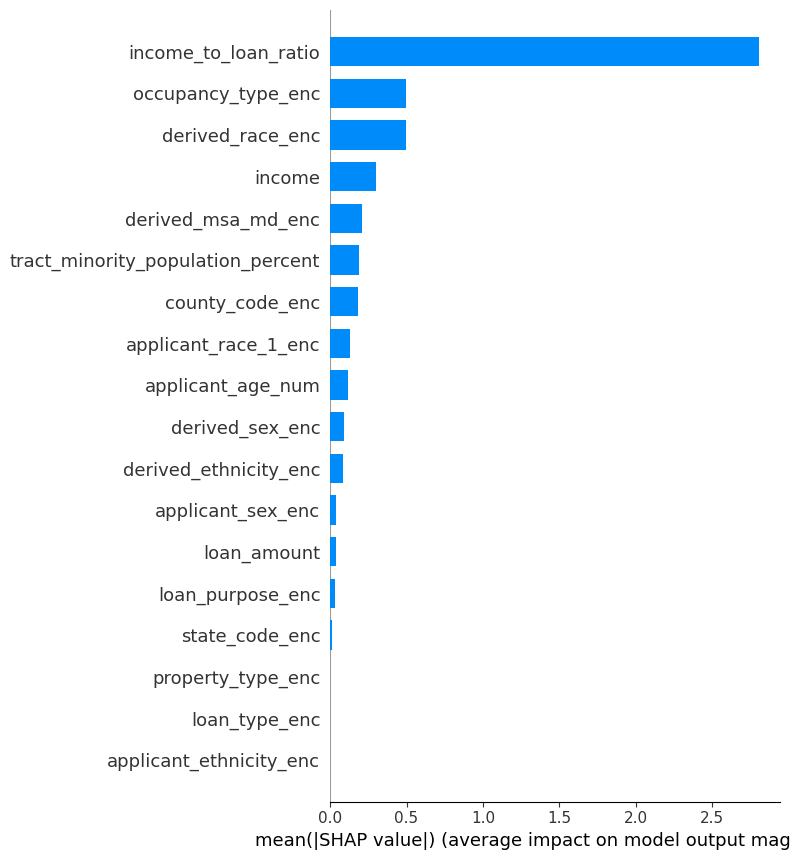

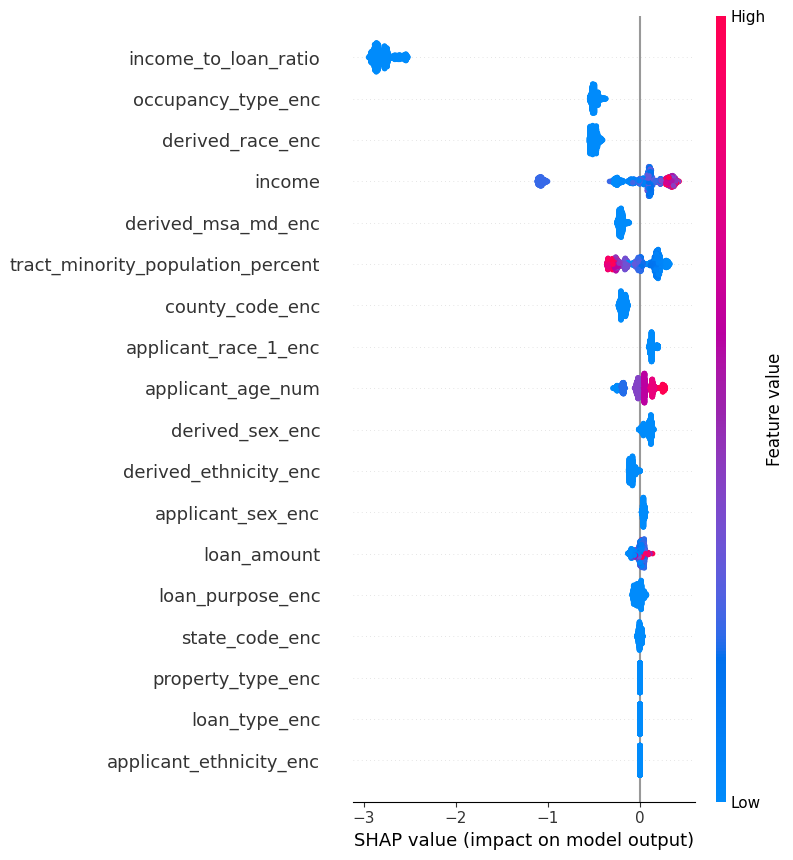

All SHAP plots saved to reports\shap


In [39]:
"""
Day 5 — Explainability pipeline (run in one shot)

Enhanced version (Option A): attempts to reconstruct the preprocessing output if a preprocessor object isn't available.

Inputs (expected in repo root or /mnt/data):
- /mnt/data/xgboost_best.joblib        (trained model saved with joblib)
- /mnt/data/feature_list.txt           (one feature per line, includes target 'approved_flag')
- /mnt/data/cleaned_strict.csv         (processed dataset that matches features)
- /mnt/data/encodings.json             (optional: contains encoding maps used during preprocessing)
- /mnt/data/feature_build_log.json     (optional: list of features produced)

Outputs (created):
- reports/shap/                        (all PNG + HTML explainability files)
- reports/explainability_summary.md    (markdown summary)
- reports/shap/feature_alignment_debug.txt

Run:
$ python day5_explainability.py
"""

import os
import sys
import json
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import shap
except Exception:
    print("shap is not installed. Please install with: pip install shap")
    raise

# --- Paths ---

MODEL_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\models")
FEATURE_LIST_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\artifacts")
CLEANED_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\artifacts")

MODEL_PATH = MODEL_PATH / "xgboost_best.joblib"
FEATURE_LIST_PATH = FEATURE_LIST_PATH / "feature_list.txt"
CLEANED_PATH = CLEANED_PATH / "cleaned_strict.csv"
ENCODINGS_PATH = CLEANED_PATH / "encodings.json"
FEATURE_BUILD_LOG = CLEANED_PATH / "feature_build_log.json"

OUT_DIR = Path("reports") / "shap"
OUT_DIR.mkdir(parents=True, exist_ok=True)

SUMMARY_MD = Path("reports") / "explainability_summary.md"
Path("reports").mkdir(exist_ok=True)


# --- Helpers ---
def safe_load_model(path):
    return joblib.load(path)


def load_feature_list(path):
    with open(path, "r") as f:
        return [line.strip() for line in f if line.strip()]


def load_json(path):
    if not path.exists():
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except Exception:
        return None


def ensure_feature_order_and_align(
    X: pd.DataFrame,
    feature_list: list,
    model,
    encodings=None,
    full_X=None,
    debug_out=OUT_DIR / "feature_alignment_debug.txt",
):
    """Aligns X to model expected features, tries to reconstruct missing encodings if possible."""
    debug_lines = []

    # Determine expected names
    model_expected = None
    try:
        if hasattr(model, "feature_names_in_"):
            model_expected = list(model.feature_names_in_)
            debug_lines.append(f"model.feature_names_in_ found ({len(model_expected)} features)\\n")
    except Exception:
        pass

    try:
        if hasattr(model, "get_booster"):
            booster = model.get_booster()
            if hasattr(booster, "feature_names") and booster.feature_names is not None:
                model_expected = list(booster.feature_names)
                debug_lines.append(f"booster.feature_names found ({len(model_expected)} features)\\n")
    except Exception:
        pass

    # fallback to feature_list
    if model_expected is None:
        feats = [f for f in feature_list if f != "approved_flag"]
        model_expected = feats
        debug_lines.append("No feature names found in model, using feature_list.txt.\\n")

    debug_lines.append(f"Expected {len(model_expected)} features.\\n")
    debug_lines.append(f"Sample expected: {model_expected[:20]}\\n")
    debug_lines.append(f"X shape before: {X.shape}\\n")
    debug_lines.append(f"X columns before: {list(X.columns)[:20]}\\n")

    cols_X = list(X.columns)
    missing = [c for c in model_expected if c not in cols_X]
    extra = [c for c in cols_X if c not in model_expected]
    debug_lines.append(f"Missing features: {missing}\\n")
    debug_lines.append(f"Extra features: {extra}\\n")

    # Try reconstruction if encodings + full_X available
    if missing and encodings is not None and full_X is not None:
        debug_lines.append("Trying to reconstruct missing encoded columns...\\n")
        for feat in missing[:]:
            if feat.endswith("_enc"):
                raw_base = feat.replace("_enc", "")
                candidates = [raw_base, raw_base.replace("derived_", ""), raw_base + "_1"]
                found_raw = next((c for c in candidates if c in full_X.columns), None)
                if found_raw:
                    enc_map = encodings.get(feat) if isinstance(encodings, dict) else None
                    if enc_map:
                        try:
                            mapped = full_X[found_raw].map(lambda x: enc_map.get(str(x), np.nan))
                            fill_val = mapped.median() if pd.api.types.is_numeric_dtype(mapped) else 0
                            X[feat] = mapped.fillna(fill_val).loc[X.index]
                            missing.remove(feat)
                            debug_lines.append(f"Reconstructed {feat} from {found_raw} using enc_map.\\n")
                        except Exception as e:
                            debug_lines.append(f"Failed reconstruction for {feat}: {e}\\n")

    # Fill remaining missing with median/mode/0
    if missing:
        debug_lines.append("Filling remaining missing features with median/mode/0.\\n")
        for c in missing:
            if full_X is not None and c in full_X.columns:
                if pd.api.types.is_numeric_dtype(full_X[c]):
                    fill_val = full_X[c].median()
                else:
                    fill_val = full_X[c].mode().iloc[0] if not full_X[c].mode().empty else 0
                X[c] = fill_val
                debug_lines.append(f"Filled {c} with value {fill_val}.\\n")
            else:
                X[c] = 0
                debug_lines.append(f"Created {c} filled with 0.\\n")

    # Ensure order
    X = X.reindex(columns=model_expected)
    debug_lines.append(f"X shape after: {X.shape}\\n")
    debug_lines.append(f"X columns after: {list(X.columns)[:20]}\\n")

    with open(debug_out, "w") as fh:
        fh.writelines(debug_lines)

    return X


# --- Main ---
if __name__ == "__main__":
    for p in [MODEL_PATH, FEATURE_LIST_PATH, CLEANED_PATH]:
        if not p.exists():
            print(f"Required file missing: {p}")
            sys.exit(1)

    print("Loading model...")
    model = safe_load_model(MODEL_PATH)

    print("Loading feature list...")
    feature_list = load_feature_list(FEATURE_LIST_PATH)

    print("Loading cleaned dataset...")
    df = pd.read_csv(CLEANED_PATH)

    encodings = load_json(ENCODINGS_PATH)
    fb_log = load_json(FEATURE_BUILD_LOG)

    target_col = "approved_flag"
    if target_col in df.columns:
        y = df[target_col]
        X_full = df.drop(columns=[target_col])
    else:
        y = None
        X_full = df

    SAMPLE_N = 2000
    if X_full.shape[0] > SAMPLE_N:
        sample = df.sample(n=SAMPLE_N, random_state=42)
        X_sample = sample.drop(columns=[target_col]) if target_col in sample else sample
    else:
        X_sample = X_full

    # Align
    X_sample_aligned = ensure_feature_order_and_align(
        X_sample, feature_list, model, encodings=encodings, full_X=X_full
    )

    print("Building SHAP explainer...")
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_sample_aligned)
    except Exception as e:
        print("TreeExplainer failed, falling back:", e)
        background = shap.sample(X_sample_aligned, nsamples=100, random_state=42)
        predict_fn = model.predict_proba if hasattr(model, "predict_proba") else model.predict
        explainer = shap.KernelExplainer(predict_fn, background)
        shap_values = explainer.shap_values(X_sample_aligned)

    # Global plots
    shap.summary_plot(shap_values, X_sample_aligned, plot_type="bar", show=False)
    plt.savefig(OUT_DIR / "shap_summary_bar.png", dpi=200)
    plt.show()
    plt.close()

    shap.summary_plot(shap_values, X_sample_aligned, plot_type="dot", show=False)
    plt.savefig(OUT_DIR / "shap_summary_beeswarm.png", dpi=200)
    plt.show()
    plt.close()

    print("All SHAP plots saved to", OUT_DIR)


Loading model...
Loading dataset...
Loading feature list & encodings...
Preparing numeric X_proc (this may take a moment)...
Model expects 18 features. Example: ['loan_amount', 'income', 'income_to_loan_ratio', 'applicant_age_num', 'applicant_race_1_enc', 'applicant_sex_enc', 'applicant_ethnicity_enc', 'derived_race_enc', 'derived_ethnicity_enc', 'derived_sex_enc', 'loan_type_enc', 'loan_purpose_enc', 'occupancy_type_enc', 'property_type_enc', 'state_code_enc', 'county_code_enc', 'derived_msa_md_enc', 'tract_minority_population_percent']
Prepared X_proc shape: (4670, 18)
loan_amount                            int64
income                               float64
income_to_loan_ratio                 float64
applicant_age_num                    float64
applicant_race_1_enc                 float64
applicant_sex_enc                    float64
applicant_ethnicity_enc              float64
derived_race_enc                     float64
derived_ethnicity_enc                float64
derived_sex_enc  

<Figure size 600x500 with 0 Axes>

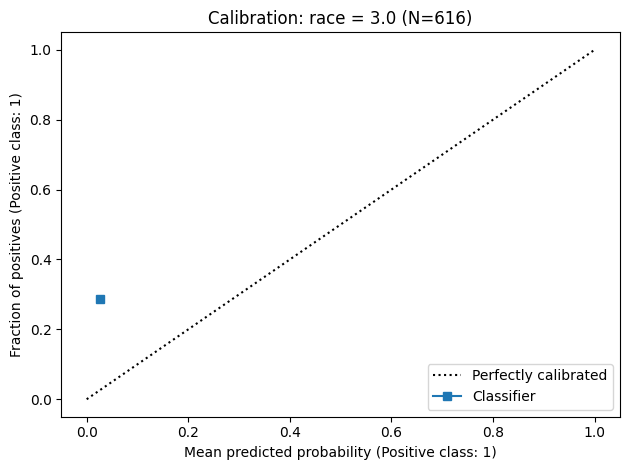

<Figure size 600x500 with 0 Axes>

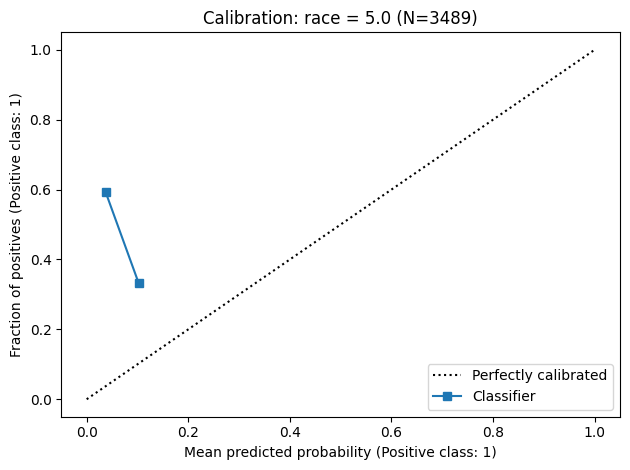

<Figure size 600x500 with 0 Axes>

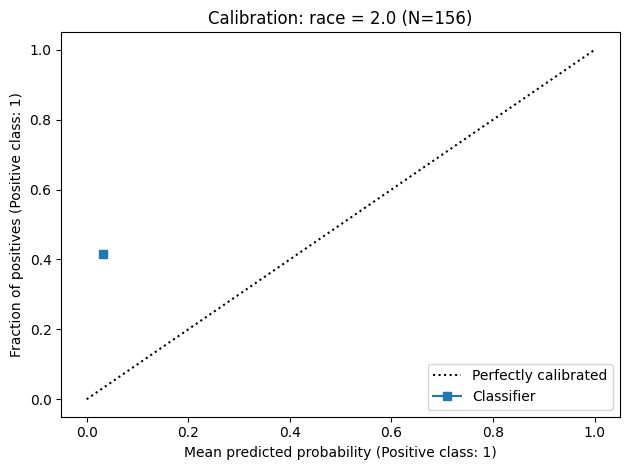

<Figure size 600x500 with 0 Axes>

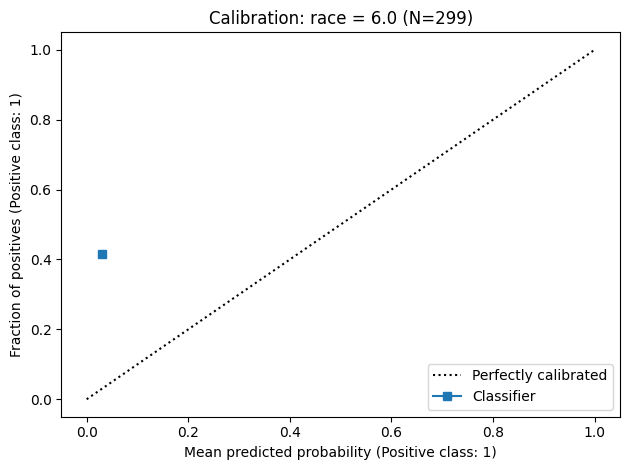

<Figure size 600x500 with 0 Axes>

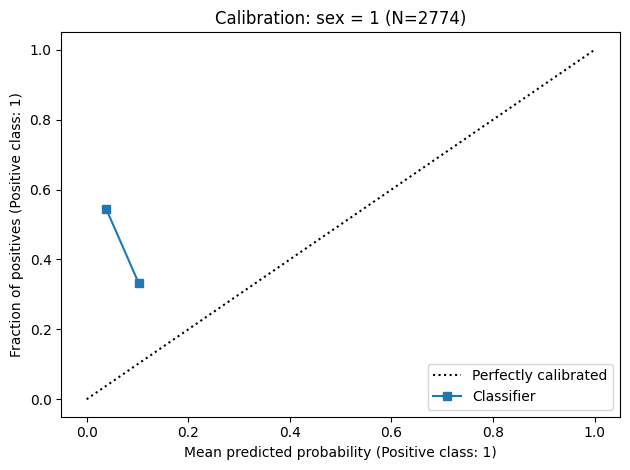

<Figure size 600x500 with 0 Axes>

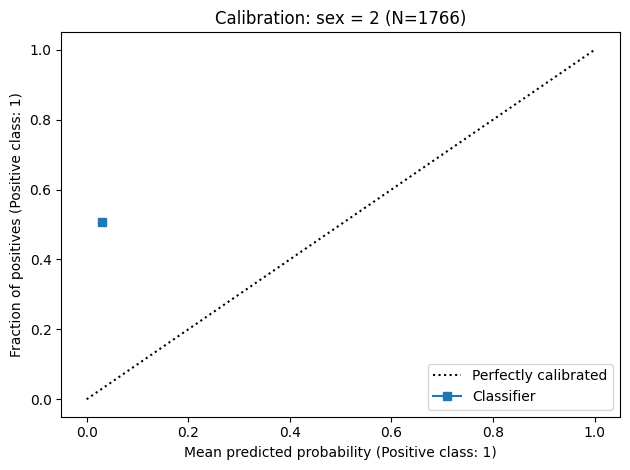

<Figure size 600x500 with 0 Axes>

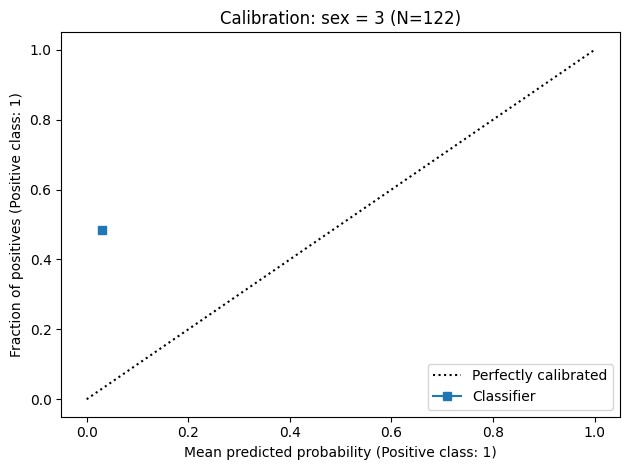

<Figure size 600x500 with 0 Axes>

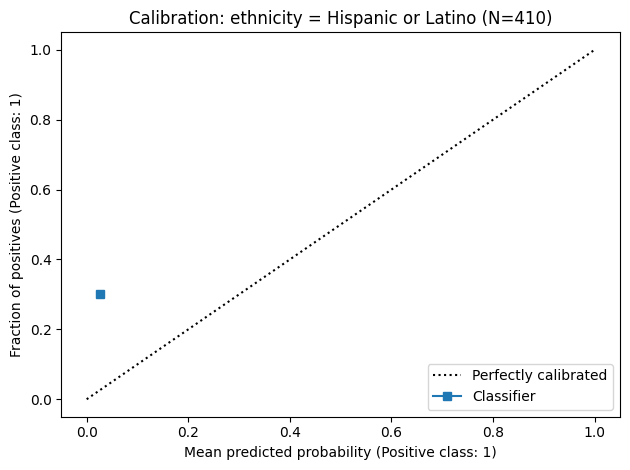

<Figure size 600x500 with 0 Axes>

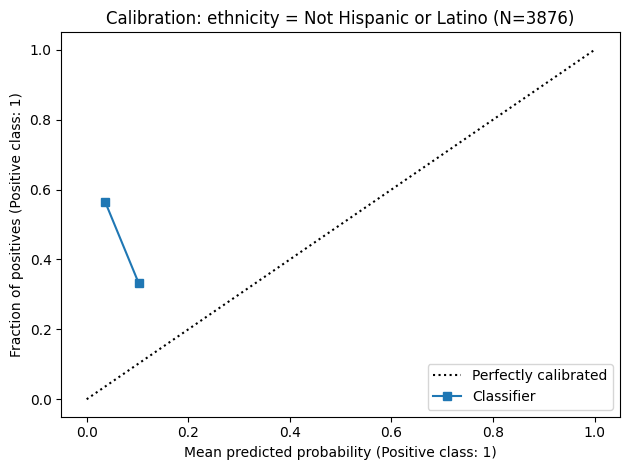

<Figure size 600x500 with 0 Axes>

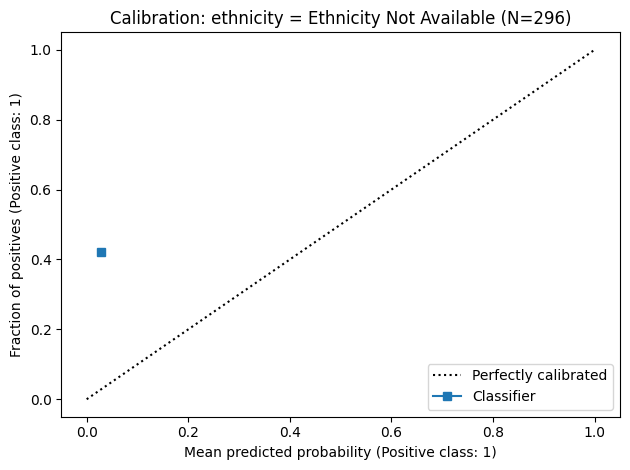

<Figure size 600x500 with 0 Axes>

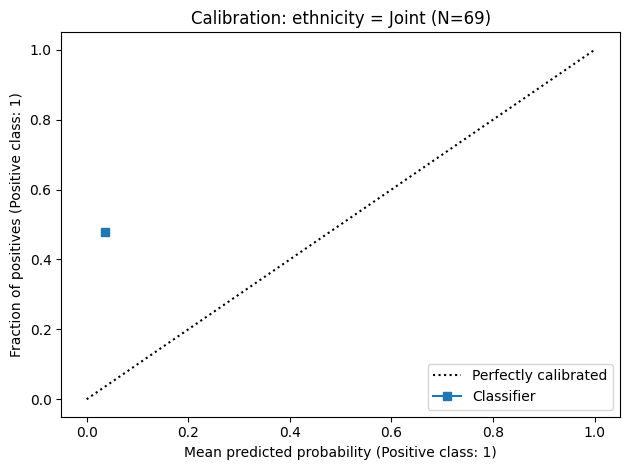

Running ThresholdOptimizer (fairlearn)...
Done. Outputs written to 'reports' folder.
Check: reports\fairness_metrics_by_group.csv  and plots in: reports\fairness_plots


In [46]:
# Jupyter-friendly Day 6 fairness audit
# Paste entire cell into a notebook and run.

import sys
from pathlib import Path
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
try:
    from sklearn.metrics import confusion_matrix, precision_score, recall_score
    from sklearn.calibration import CalibrationDisplay
except Exception as e:
    print("Missing scikit-learn. Install: pip install scikit-learn")
    raise e

# fairlearn (optional)
try:
    from fairlearn.postprocessing import ThresholdOptimizer
    from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
    FAIRLEARN_AVAILABLE = True
except Exception:
    FAIRLEARN_AVAILABLE = False

# ---------------- CONFIGURE ----------------
# Change this to the folder where your model and data live (Windows example):
MODEL_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\models")
FEATURE_LIST_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\artifacts")
CLEANED_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\artifacts")

MODEL_PATH = MODEL_PATH / "xgboost_best.joblib"
FEATURE_LIST_PATH = FEATURE_LIST_PATH / "feature_list.txt"
CLEANED_PATH = CLEANED_PATH / "cleaned_strict.csv"
ENCODINGS_PATH = CLEANED_PATH / "encodings.json"
FEATURE_BUILD_LOG = CLEANED_PATH / "feature_build_log.json"

OUT_DIR = Path("reports")
OUT_DIR.mkdir(exist_ok=True)
PLOT_DIR = OUT_DIR / "fairness_plots"
PLOT_DIR.mkdir(exist_ok=True)

DEBUG_PATH = OUT_DIR / "fairness_debug.txt"
SUMMARY_MD = OUT_DIR / "fairness_summary.md"
METRICS_CSV = OUT_DIR / "fairness_metrics_by_group.csv"

# ---------------- Helpers ----------------
def require_file(p: Path, name: str):
    if not p.exists():
        raise FileNotFoundError(f"Required {name} missing at: {p}")

def safe_load_model(path: Path):
    return joblib.load(path)

def load_feature_list(path: Path):
    with open(path, "r") as f:
        return [line.strip() for line in f if line.strip()]

def load_json_if_exists(path: Path):
    if path.exists():
        try:
            return json.load(open(path, "r"))
        except Exception:
            return None
    return None

def get_predict_proba_fn(model):
    # Prefer predict_proba
    try:
        if hasattr(model, "predict_proba"):
            def pf(X):
                probs = model.predict_proba(X)
                if hasattr(probs, "shape") and probs.shape[1] >= 2:
                    return probs[:, 1]
                else:
                    return probs.ravel()
            return pf
    except Exception:
        pass
    # fallback: predict (assume returns scores/probs)
    if hasattr(model, "predict"):
        def pf2(X):
            return model.predict(X).ravel()
        return pf2
    # xgboost booster fallback
    try:
        import xgboost as xgb
        booster = model.get_booster()
        def pf3(X):
            dm = xgb.DMatrix(X)
            preds = booster.predict(dm)
            return preds.ravel()
        return pf3
    except Exception:
        pass
    return None

def group_metrics(y_true, y_pred_label):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_label, labels=[0,1]).ravel()
    precision = precision_score(y_true, y_pred_label, zero_division=0)
    recall = recall_score(y_true, y_pred_label, zero_division=0)
    tpr = recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    return {"TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
            "TPR": float(tpr), "FPR": float(fpr),
            "precision": float(precision), "recall": float(recall),
            "support": int((y_true==1).sum())}

def detect_model_expected_columns(model, fallback_feature_list):
    expected = None
    try:
        if hasattr(model, "feature_names_in_"):
            expected = list(model.feature_names_in_)
    except Exception:
        pass
    try:
        if expected is None and hasattr(model, "get_booster"):
            booster = model.get_booster()
            if hasattr(booster, "feature_names") and booster.feature_names is not None:
                expected = list(booster.feature_names)
    except Exception:
        pass
    if expected is None:
        expected = [f for f in fallback_feature_list if f != "approved_flag"]
    return expected

# ---------------- Run ----------------
try:
    require_file(MODEL_PATH, "model")
    require_file(FEATURE_LIST_PATH, "feature_list")
    require_file(CLEANED_PATH, "cleaned_strict.csv")
except FileNotFoundError as e:
    print(str(e))
    raise

print("Loading model...")
model = safe_load_model(MODEL_PATH)

print("Loading dataset...")
df = pd.read_csv(CLEANED_PATH)

print("Loading feature list & encodings...")
feature_list = load_feature_list(FEATURE_LIST_PATH)
encodings = load_json_if_exists(ENCODINGS_PATH)
fb_log = load_json_if_exists(FEATURE_BUILD_LOG)

if "approved_flag" not in df.columns:
    raise RuntimeError("approved_flag target column is missing in cleaned_strict.csv")

y = df["approved_flag"].astype(int)
X_raw = df.drop(columns=["approved_flag"])

# Build numeric X_proc
print("Preparing numeric X_proc (this may take a moment)...")
model_expected = detect_model_expected_columns(model, feature_list)
print(f"Model expects {len(model_expected)} features. Example: {model_expected[:20]}")

X_proc = pd.DataFrame(index=X_raw.index)
for feat in model_expected:
    if feat in X_raw.columns:
        X_proc[feat] = X_raw[feat]
        continue

    # heuristics for *_enc
    if feat.endswith("_enc"):
        raw_candidate = feat.replace("_enc", "")
        candidates = [raw_candidate, raw_candidate + "_1", "derived_" + raw_candidate, raw_candidate.replace("derived_", "")]
        found = next((c for c in candidates if c in X_raw.columns), None)
        if found:
            enc_map = encodings.get(feat) if isinstance(encodings, dict) else None
            if enc_map:
                try:
                    mapped = X_raw[found].map(lambda x: enc_map.get(str(x), np.nan))
                    if mapped.notna().sum() > 0:
                        X_proc[feat] = mapped.fillna(mapped.median() if pd.api.types.is_numeric_dtype(mapped) else 0)
                        continue
                except Exception:
                    pass
            # fallback categorical codes
            try:
                codes = pd.Categorical(X_raw[found]).codes
                X_proc[feat] = pd.Series(codes, index=X_raw.index).astype(float)
                continue
            except Exception:
                pass

    # try numeric coercion if same name exists
    if feat in X_raw.columns:
        try:
            X_proc[feat] = pd.to_numeric(X_raw[feat], errors="coerce")
            continue
        except Exception:
            pass

    # fallback zero column
    X_proc[feat] = 0.0

# coerce object columns to numeric where possible, else codes
for c in X_proc.columns:
    if X_proc[c].dtype == "object":
        coerced = pd.to_numeric(X_proc[c], errors="coerce")
        if coerced.notna().sum() > 0:
            X_proc[c] = coerced
        else:
            X_proc[c] = pd.Categorical(X_proc[c]).codes.astype(float)

# fill NaNs
for c in X_proc.columns:
    if pd.api.types.is_numeric_dtype(X_proc[c]):
        if X_proc[c].isna().any():
            med = X_proc[c].median()
            if pd.isna(med):
                med = 0.0
            X_proc[c] = X_proc[c].fillna(med)
    else:
        try:
            mode = X_proc[c].mode().iloc[0]
            X_proc[c] = X_proc[c].fillna(mode)
        except Exception:
            X_proc[c] = X_proc[c].fillna(0)

X_proc = X_proc.reindex(columns=model_expected)
print("Prepared X_proc shape:", X_proc.shape)
print(X_proc.dtypes.head(20))

# Predict probabilities
predict_proba_fn = get_predict_proba_fn(model)
if predict_proba_fn is None:
    raise RuntimeError("Could not construct predict_proba function from the model. Check model API.")

try:
    probs = predict_proba_fn(X_proc)
except Exception as e:
    print("Error during predict_proba:", e)
    raise

if len(probs) != X_proc.shape[0]:
    raise RuntimeError("Length mismatch between probs and X_proc.")

y_pred_default = (probs >= 0.5).astype(int)

# sensitive attributes
sensitive_candidates = {
    "race": ["applicant_race_1_enc", "derived_race_enc", "applicant_race_1", "derived_race"],
    "sex": ["applicant_sex_enc", "derived_sex_enc", "applicant_sex", "derived_sex"],
    "ethnicity": ["applicant_ethnicity_enc", "derived_ethnicity_enc", "applicant_ethnicity", "derived_ethnicity"]
}

rows = []
debug_lines = []

for attr, candidates in sensitive_candidates.items():
    found = None
    for c in candidates:
        if c in df.columns:
            found = c
            break
    if found is None:
        debug_lines.append(f"No column found for '{attr}'. Tried: {candidates}\n")
        continue

    debug_lines.append(f"Using column '{found}' for '{attr}'.\n")
    groups = df[found].fillna("MISSING")
    for g in pd.Series(groups.unique()):
        mask = (groups == g)
        if mask.sum() < 1:
            continue
        gm = group_metrics(y[mask], y_pred_default[mask])
        gm.update({"group_attr": attr, "group_value": str(g)})
        rows.append(gm)

    # MetricFrame debug
    try:
        mf = MetricFrame(metrics={"TPR": true_positive_rate, "FPR": false_positive_rate, "selection_rate": selection_rate},
                         y_true=y, y_pred=y_pred_default, sensitive_features=groups)
        debug_lines.append(f"MetricFrame groups for {attr}: {mf.by_group.index.tolist()}\n")
    except Exception as e:
        debug_lines.append(f"MetricFrame compute failed for {attr}: {e}\n")

    # calibration plots
    for g in pd.Series(groups.unique()).tolist():
        mask = groups == g
        if mask.sum() < 30:
            debug_lines.append(f"Skipping calibration plot for {attr}={g} due to small N={mask.sum()}\n")
            continue
        try:
            plt.figure(figsize=(6,5))
            CalibrationDisplay.from_predictions(y[mask], probs[mask], n_bins=10)
            plt.title(f"Calibration: {attr} = {g} (N={mask.sum()})")
            fname = PLOT_DIR / f"calibration_{attr}_{str(g).replace('/','_')}.png"
            plt.tight_layout()
            plt.savefig(fname, dpi=200)
            plt.show()
            plt.close()
            debug_lines.append(f"Wrote calibration plot: {fname}\n")
        except Exception as e:
            debug_lines.append(f"Failed calibration plot for {attr}={g}: {e}\n")

# save metrics CSV
if rows:
    df_metrics = pd.DataFrame(rows)
    df_metrics.to_csv(METRICS_CSV, index=False)
    debug_lines.append(f"Wrote group metrics CSV: {METRICS_CSV}\n")
else:
    debug_lines.append("No group metric rows produced.\n")

# ThresholdOptimizer (fairlearn) optional
threshold_plot_path = OUT_DIR / "fairness_threshold_optimizer_comparison.png"
if FAIRLEARN_AVAILABLE:
    try:
        print("Running ThresholdOptimizer (fairlearn)...")
        sensitive_name = None
        for cands in sensitive_candidates.values():
            for cand in cands:
                if cand in df.columns:
                    sensitive_name = cand
                    break
            if sensitive_name:
                break

        if sensitive_name:
            sensitive_feature = df[sensitive_name].astype(str)
        else:
            sensitive_feature = None

        if hasattr(model, "predict_proba") or hasattr(model, "predict"):
            to = ThresholdOptimizer(estimator=model,
                                    constraints="equalized_odds",
                                    prefit=True,
                                    predict_method="predict_proba" if hasattr(model, "predict_proba") else "predict")
            to.fit(X_proc, y, sensitive_features=sensitive_feature)
            y_pred_to = to.predict(X_proc, sensitive_features=sensitive_feature)

            groups = sensitive_feature if sensitive_feature is not None else pd.Series(["all"]*len(y))
            unique_groups = pd.Series(groups.unique()).tolist()
            before_tprs = {}
            after_tprs = {}
            for g in unique_groups:
                mask = (groups == g)
                if mask.sum() < 10:
                    continue
                before = recall_score(y[mask], y_pred_default[mask], zero_division=0)
                after = recall_score(y[mask], y_pred_to[mask], zero_division=0)
                before_tprs[str(g)] = before
                after_tprs[str(g)] = after

            plt.figure(figsize=(8,5))
            labels = list(before_tprs.keys())
            before_vals = [before_tprs[k] for k in labels]
            after_vals = [after_tprs.get(k, 0) for k in labels]
            x = np.arange(len(labels))
            width = 0.35
            plt.bar(x - width/2, before_vals, width, label="Before")
            plt.bar(x + width/2, after_vals, width, label="After (ThresholdOpt)")
            plt.xticks(x, labels, rotation=45, ha="right")
            plt.ylabel("TPR (Recall)")
            plt.title("TPR before vs after ThresholdOptimizer by group")
            plt.legend()
            plt.tight_layout()
            plt.savefig(threshold_plot_path, dpi=200)
            plt.show()
            plt.close()
            debug_lines.append(f"Wrote ThresholdOptimizer comparison plot: {threshold_plot_path}\n")
        else:
            debug_lines.append("Model has neither predict_proba nor predict; skipping ThresholdOptimizer.\n")
    except Exception as e:
        debug_lines.append(f"ThresholdOptimizer failed: {e}\n")
else:
    debug_lines.append("fairlearn not available; skipping ThresholdOptimizer. Install: pip install fairlearn\n")

# Write summary and debug
md_lines = []
md_lines.append("# Fairness & Bias Audit (Day 6)\n\n")
md_lines.append("Auto-generated by notebook script.\n\n")
md_lines.append("## Files generated\n")
md_lines.append(f"- `{METRICS_CSV.name}` — metrics per group (TPR, FPR, precision, recall, support)\n")
md_lines.append(f"- `fairness_plots/` — calibration plots per group and threshold optimizer comparison (if run)\n")
md_lines.append("- `fairness_debug.txt` — debug/log information\n\n")

if rows:
    md_lines.append("## Top findings (auto-generated)\n")
    dfm = pd.DataFrame(rows)
    if not dfm.empty:
        for attr in ["race", "sex", "ethnicity"]:
            s = dfm[dfm["group_attr"] == attr]
            if not s.empty:
                min_tpr = s["TPR"].min()
                max_tpr = s["TPR"].max()
                worst = s.loc[s["TPR"].idxmin()]["group_value"]
                best = s.loc[s["TPR"].idxmax()]["group_value"]
                md_lines.append(f"- {attr}: TPR range = {min_tpr:.3f} — {max_tpr:.3f} (best: {best}, worst: {worst})\n")
else:
    md_lines.append("No group metrics were produced. Check `fairness_debug.txt`.\n")

if FAIRLEARN_AVAILABLE:
    md_lines.append("\nNote: ThresholdOptimizer (equalized_odds) was attempted since fairlearn is installed.\n")
else:
    md_lines.append("\nNote: `fairlearn` not installed; no mitigation applied. Install: pip install fairlearn\n")

SUMMARY_MD.write_text("".join(md_lines))
with open(DEBUG_PATH, "w") as fh:
    fh.writelines(debug_lines)

print("Done. Outputs written to 'reports' folder.")
print("Check:", METRICS_CSV, " and plots in:", PLOT_DIR)


Loading artifacts...
Model expects 18 features.
X_proc shape: (4670, 18)

Running GroupKFold robustness checks...
Using group: state_code_enc
 Fold 1: n=1426, acc=0.485, recall=0.000, auc=0.7145938549080993
 Fold 2: n=810, acc=0.481, recall=0.000, auc=0.7216971916971917
 Fold 3: n=809, acc=0.351, recall=0.000, auc=0.7347753185781355
 Fold 4: n=810, acc=0.480, recall=0.000, auc=0.7600614279869816
 Fold 5: n=815, acc=0.545, recall=0.000, auc=0.7090132585415605


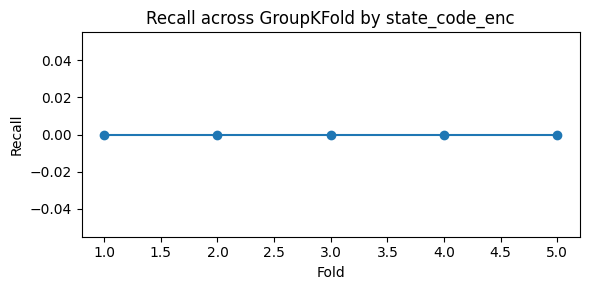

Using group: loan_type_enc
 Fold 1: n=4667, acc=0.470, recall=0.000, auc=0.730256043081142
 Fold 2: n=3, acc=1.000, recall=0.000, auc=nan


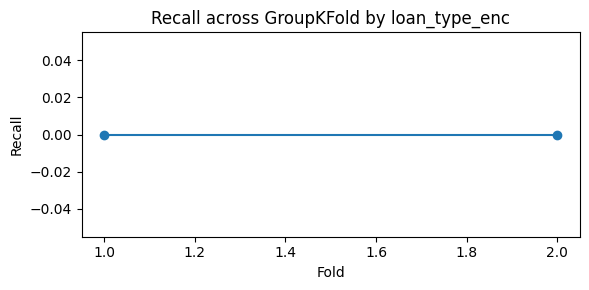


Performing error analysis...

Running feature ablation experiments (retraining lightweight XGBoost)...
Ablating: income_to_loan_ratio
  -> acc: 0.7248394004282656  recall: 0.7631578947368421  auc: 0.7945528156054471
Ablating: occupancy_type_enc
  -> acc: 0.7184154175588865  recall: 0.757085020242915  auc: 0.7964942951785057
Ablating: derived_race_enc
  -> acc: 0.7098501070663812  recall: 0.7489878542510121  auc: 0.7801527419948472
Ablating: income
  -> acc: 0.645610278372591  recall: 0.6781376518218624  auc: 0.6989970555760029


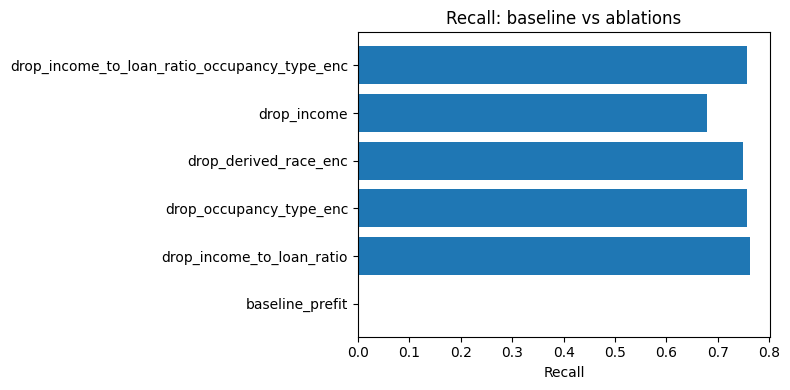


Day 7 complete — outputs saved in 'reports/' (robustness_summary.json, errors_by_*.csv, ablation_results.json, plots).


In [48]:
# Day 7 — Robustness & Error Analysis (Jupyter-friendly)
# Paste whole cell into a notebook, edit DATA_DIR, then run.

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import time

# ---------------- CONFIG ----------------
MODEL_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\models")
FEATURE_LIST_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\artifacts")
CLEANED_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\artifacts")
  # <-- set this
MODEL_PATH = MODEL_PATH / "xgboost_best.joblib"
FEATURE_LIST_PATH = FEATURE_LIST_PATH / "feature_list.txt"
CLEANED_PATH = CLEANED_PATH / "cleaned_strict.csv"
ENCODINGS_PATH = CLEANED_PATH / "encodings.json"

OUT_DIR = Path("reports")
OUT_DIR.mkdir(exist_ok=True)
PLOT_DIR = OUT_DIR / "robustness_plots"
PLOT_DIR.mkdir(exist_ok=True)
ABLATION_DIR = OUT_DIR / "ablation"
ABLATION_DIR.mkdir(exist_ok=True)

# ---------------- utilities (reused pattern) ----------------
def load_feature_list(p):
    with open(p, "r") as f:
        return [l.strip() for l in f if l.strip()]

def load_json_if_exists(p):
    if p.exists():
        try:
            return json.load(open(p, "r"))
        except Exception:
            return None
    return None

def safe_load_model(p):
    return joblib.load(p)

def detect_model_expected_columns(model, fallback_feature_list):
    expected = None
    try:
        if hasattr(model, "feature_names_in_"):
            expected = list(model.feature_names_in_)
    except Exception:
        pass
    try:
        if expected is None and hasattr(model, "get_booster"):
            booster = model.get_booster()
            if hasattr(booster, "feature_names") and booster.feature_names is not None:
                expected = list(booster.feature_names)
    except Exception:
        pass
    if expected is None:
        expected = [f for f in fallback_feature_list if f != "approved_flag"]
    return expected

def build_X_proc(X_raw, model_expected, encodings=None):
    X_proc = pd.DataFrame(index=X_raw.index)
    for feat in model_expected:
        if feat in X_raw.columns:
            X_proc[feat] = X_raw[feat]
            continue
        if feat.endswith("_enc"):
            raw_candidate = feat.replace("_enc", "")
            candidates = [raw_candidate, raw_candidate + "_1", "derived_" + raw_candidate, raw_candidate.replace("derived_", "")]
            found = next((c for c in candidates if c in X_raw.columns), None)
            if found:
                enc_map = encodings.get(feat) if isinstance(encodings, dict) else None
                if enc_map:
                    try:
                        mapped = X_raw[found].map(lambda x: enc_map.get(str(x), np.nan))
                        if mapped.notna().sum() > 0:
                            X_proc[feat] = mapped.fillna(mapped.median() if pd.api.types.is_numeric_dtype(mapped) else 0)
                            continue
                    except Exception:
                        pass
                try:
                    codes = pd.Categorical(X_raw[found]).codes
                    X_proc[feat] = pd.Series(codes, index=X_raw.index).astype(float)
                    continue
                except Exception:
                    pass
        # fallback create zero
        X_proc[feat] = 0.0
    # coerce and fill
    for c in X_proc.columns:
        if X_proc[c].dtype == "object":
            coerced = pd.to_numeric(X_proc[c], errors="coerce")
            if coerced.notna().sum() > 0:
                X_proc[c] = coerced
            else:
                X_proc[c] = pd.Categorical(X_proc[c]).codes.astype(float)
    for c in X_proc.columns:
        if pd.api.types.is_numeric_dtype(X_proc[c]):
            if X_proc[c].isna().any():
                med = X_proc[c].median()
                X_proc[c] = X_proc[c].fillna(0.0 if pd.isna(med) else med)
        else:
            X_proc[c] = X_proc[c].fillna(0)
    X_proc = X_proc.reindex(columns=model_expected)
    return X_proc

def metrics_for_labels(y_true, y_pred, y_score=None):
    out = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
    }
    if y_score is not None:
        try:
            out["auc"] = float(roc_auc_score(y_true, y_score))
        except Exception:
            out["auc"] = None
    return out

# ---------------- load artifacts ----------------
print("Loading artifacts...")
model = safe_load_model(MODEL_PATH)
feature_list = load_feature_list(FEATURE_LIST_PATH)
encodings = load_json_if_exists(ENCODINGS_PATH)
df = pd.read_csv(CLEANED_PATH)

if "approved_flag" not in df.columns:
    raise RuntimeError("approved_flag not present")

y = df["approved_flag"].astype(int)
X_raw = df.drop(columns=["approved_flag"])

# determine model features & prepare X_proc
model_expected = detect_model_expected_columns(model, feature_list)
print("Model expects", len(model_expected), "features.")
X_proc = build_X_proc(X_raw, model_expected, encodings=encodings)
print("X_proc shape:", X_proc.shape)

# safe predict_proba util
def get_predict_proba_fn(model):
    try:
        if hasattr(model, "predict_proba"):
            def pf(X):
                probs = model.predict_proba(X)
                return probs[:,1] if probs.ndim>1 else probs.ravel()
            return pf
    except Exception:
        pass
    if hasattr(model, "predict"):
        def pf2(X):
            return model.predict(X).ravel()
        return pf2
    try:
        import xgboost as xgb
        booster = model.get_booster()
        def pf3(X):
            dm = xgb.DMatrix(X)
            return booster.predict(dm).ravel()
        return pf3
    except Exception:
        return None

predict_proba = get_predict_proba_fn(model)
if predict_proba is None:
    raise RuntimeError("Model doesn't expose predict/predict_proba")

probs = predict_proba(X_proc)
preds = (probs >= 0.5).astype(int)

# ---------------- 1) Robustness: GroupKFold by geography & loan type ----------------
print("\nRunning GroupKFold robustness checks...")
results = {}
group_candidates = []
# choose group columns that exist (encoded or raw)
if "state_code_enc" in X_proc.columns:
    group_candidates.append("state_code_enc")
elif "state_code" in X_raw.columns:
    group_candidates.append("state_code")
if "loan_type_enc" in X_proc.columns:
    group_candidates.append("loan_type_enc")
elif "loan_type" in X_raw.columns:
    group_candidates.append("loan_type")

for gc in group_candidates:
    print("Using group:", gc)
    groups = X_proc[gc] if gc in X_proc.columns else X_raw[gc]
    gkf = GroupKFold(n_splits=min(5, groups.nunique() if groups.nunique()>1 else 2))
    fold_metrics = []
    for fold, (tr_idx, te_idx) in enumerate(gkf.split(X_proc, y, groups)):
        Xtr, Xte = X_proc.iloc[tr_idx], X_proc.iloc[te_idx]
        ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]
        # evaluate model (prefit)
        try:
            pte = predict_proba(Xte)
            predte = (pte >= 0.5).astype(int)
            m = metrics_for_labels(yte, predte, pte)
            m["n_test"] = int(len(te_idx))
            fold_metrics.append(m)
            print(f" Fold {fold+1}: n={len(te_idx)}, acc={m['accuracy']:.3f}, recall={m['recall']:.3f}, auc={m.get('auc')}")
        except Exception as e:
            print(" Fold eval failed:", e)
    results[gc] = fold_metrics
    # plot recall per fold
    plt.figure(figsize=(6,3))
    recalls = [fm["recall"] for fm in fold_metrics]
    plt.plot(range(1,len(recalls)+1), recalls, marker="o")
    plt.xlabel("Fold"); plt.ylabel("Recall"); plt.title(f"Recall across GroupKFold by {gc}")
    plt.tight_layout()
    plt.savefig(PLOT_DIR / f"robustness_recall_by_{gc}.png", dpi=200)
    plt.show()
    plt.close()

# save robustness summary
with open(OUT_DIR / "robustness_summary.json","w") as fh:
    json.dump(results, fh, indent=2)

# ---------------- 2) Error analysis: FP/FN breakdown by subgroup ----------------
print("\nPerforming error analysis...")
df_errors = df.copy()
df_errors["_prob"] = probs
df_errors["_pred"] = preds
df_errors["_actual"] = y

# define function to compute fp/fn rates per group
def error_breakdown(df_errors, group_col, min_size=20):
    rows=[]
    if group_col not in df_errors.columns:
        return pd.DataFrame(rows)
    for g, sub in df_errors.groupby(group_col):
        n = len(sub)
        if n < min_size:
            continue
        fp = int(((sub["_pred"]==1) & (sub["_actual"]==0)).sum())
        fn = int(((sub["_pred"]==0) & (sub["_actual"]==1)).sum())
        tp = int(((sub["_pred"]==1) & (sub["_actual"]==1)).sum())
        tn = int(((sub["_pred"]==0) & (sub["_actual"]==0)).sum())
        rows.append({"group_col": group_col, "group": str(g), "n": n, "TP":tp, "FP":fp, "TN":tn, "FN":fn,
                     "FP_rate": fp/n, "FN_rate": fn/n, "TPR": tp/(tp+fn) if (tp+fn)>0 else None})
    return pd.DataFrame(rows)

# compute for race/sex/ethnicity/state/loan_type if columns exist
group_cols = []
for candidate in ["derived_race", "applicant_race_1", "derived_race_enc", "applicant_race_1_enc",
                  "derived_sex", "applicant_sex", "derived_sex_enc", "applicant_sex_enc",
                  "derived_ethnicity", "applicant_ethnicity", "derived_ethnicity_enc", "applicant_ethnicity_enc",
                  "state_code", "state_code_enc", "loan_type", "loan_type_enc"]:
    if candidate in df_errors.columns:
        group_cols.append(candidate)

error_tables = {}
for gc in group_cols:
    et = error_breakdown(df_errors, gc, min_size=30)
    if not et.empty:
        et = et.sort_values("FP_rate", ascending=False)
        et.to_csv(OUT_DIR / f"errors_by_{gc}.csv", index=False)
        error_tables[gc] = et.to_dict(orient="records")

# ---------------- 3) Feature ablation: retrain light XGBoost for each removal ----------------
print("\nRunning feature ablation experiments (retraining lightweight XGBoost)...")
# We'll retrain simple xgboost with default params for speed; if your original model used special params you can load them.
try:
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
except Exception:
    raise RuntimeError("Install xgboost and scikit-learn to run ablation experiments.")

# identify top features to ablate:
# use SHAP summary if available (we have feature_importance from Day5); else pick first 4 of model_expected
top_candidates = ["income_to_loan_ratio", "occupancy_type_enc", "derived_race_enc", "income"]
top_feats = [f for f in top_candidates if f in X_proc.columns]
if not top_feats:
    top_feats = model_expected[:4]

abl_results = {}
# baseline: evaluate current model (prefit) on a holdout for retraining comparability
X_train_full, X_hold, y_train_full, y_hold = train_test_split(X_proc, y, test_size=0.2, random_state=42, stratify=y)
p_hold_baseline = predict_proba(X_hold)
baseline_metrics = metrics_for_labels(y_hold, (p_hold_baseline>=0.5).astype(int), p_hold_baseline)
abl_results["baseline_prefit"] = baseline_metrics

for feat in top_feats:
    t0 = time.time()
    print("Ablating:", feat)
    # prepare reduced feature sets
    reduced_feats = [c for c in X_proc.columns if c != feat]
    X_r = X_proc[reduced_feats]
    # split retrain dataset
    Xtr, Xte, ytr, yte = train_test_split(X_r, y, test_size=0.2, random_state=42, stratify=y)
    # train lightweight xgboost (use same objective as original — binary:logistic)
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    dtest = xgb.DMatrix(Xte, label=yte)
    params = {"objective":"binary:logistic", "eval_metric":"auc", "verbosity":0}
    bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest,"eval")], verbose_eval=False)
    p_te = bst.predict(dtest)
    p_tr = bst.predict(dtrain)
    m = metrics_for_labels(yte, (p_te>=0.5).astype(int), p_te)
    m["train_time_sec"] = time.time()-t0
    abl_results[f"drop_{feat}"] = m
    # save model (optional)
    joblib.dump(bst, ABLATION_DIR / f"xgb_drop_{feat}.joblib")
    print("  -> acc:", m["accuracy"], " recall:", m["recall"], " auc:", m.get("auc"))

# combined ablation: drop top 2
combo = top_feats[:2]
if combo:
    dropped = set(combo)
    reduced_feats = [c for c in X_proc.columns if c not in dropped]
    X_r = X_proc[reduced_feats]
    Xtr, Xte, ytr, yte = train_test_split(X_r, y, test_size=0.2, random_state=42, stratify=y)
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    dtest = xgb.DMatrix(Xte, label=yte)
    params = {"objective":"binary:logistic", "eval_metric":"auc", "verbosity":0}
    bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest,"eval")], verbose_eval=False)
    p_te = bst.predict(dtest)
    abl_results[f"drop_{'_'.join(combo)}"] = metrics_for_labels(yte, (p_te>=0.5).astype(int), p_te)
    joblib.dump(bst, ABLATION_DIR / f"xgb_drop_{'_'.join(combo)}.joblib")

# save ablation results
with open(OUT_DIR / "ablation_results.json","w") as fh:
    json.dump(abl_results, fh, indent=2)

# quick plot: baseline vs ablations (recall)
labels = []
recalls = []
for k,v in abl_results.items():
    labels.append(k)
    recalls.append(v.get("recall", None))
plt.figure(figsize=(8,4))
plt.barh(labels, [r if r is not None else 0 for r in recalls])
plt.xlabel("Recall")
plt.title("Recall: baseline vs ablations")
plt.tight_layout()
plt.savefig(OUT_DIR / "ablation_recall_comparison.png", dpi=200)
plt.show()
plt.close()

# ---------------- Save summary ----------------
summary = {
    "robustness": results,
    "error_tables_sample": {k: (v[:5] if isinstance(v, list) else v) for k,v in error_tables.items()},
    "ablation": abl_results,
    "top_feats_used_for_ablation": top_feats
}
with open(OUT_DIR / "day7_summary.json","w") as fh:
    json.dump(summary, fh, indent=2)

print("\nDay 7 complete — outputs saved in 'reports/' (robustness_summary.json, errors_by_*.csv, ablation_results.json, plots).")


In [ ]:

  # <-- set this

[I 2025-09-07 12:25:17,748] A new study created in memory with name: no-name-06894fe0-118a-48c6-b382-71b8e55947f6


Loading data and baseline model...
Model expected features: 18
Prepared X_proc shape: (4670, 18)
Starting Optuna tuning (80 trials)...


Best trial: 0. Best value: 0.769568:   1%|▏         | 1/80 [00:00<00:21,  3.73it/s]

[I 2025-09-07 12:25:18,014] Trial 0 finished with value: 0.769567511384542 and parameters: {'n_estimators': 181, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 0.769567511384542.


Best trial: 1. Best value: 0.775256:   4%|▍         | 3/80 [00:00<00:15,  5.09it/s]

[I 2025-09-07 12:25:18,221] Trial 1 finished with value: 0.7752564082041209 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 0.7752564082041209.
[I 2025-09-07 12:25:18,374] Trial 2 finished with value: 0.7752009796913132 and parameters: {'n_estimators': 201, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0.569746930326021, 'colsample_bytree': 0.6460723242676091, 'min_child_weight': 4, 'gamma': 2.28034992108518, 'reg_alpha': 3.925879806965068, 'reg_lambda': 0.9983689107917987}. Best is trial 1 with value: 0.7752564082041209.


Best trial: 4. Best value: 0.776819:   6%|▋         | 5/80 [00:00<00:13,  5.54it/s]

[I 2025-09-07 12:25:18,588] Trial 3 finished with value: 0.7576824609286662 and parameters: {'n_estimators': 230, 'max_depth': 7, 'learning_rate': 0.011711509955524094, 'subsample': 0.8037724259507192, 'colsample_bytree': 0.5852620618436457, 'min_child_weight': 1, 'gamma': 4.7444276862666666, 'reg_alpha': 4.828160165372797, 'reg_lambda': 4.041986740582305}. Best is trial 1 with value: 0.7752564082041209.
[I 2025-09-07 12:25:18,730] Trial 4 finished with value: 0.7768191654382206 and parameters: {'n_estimators': 156, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'subsample': 0.7200762468698007, 'colsample_bytree': 0.5610191174223894, 'min_child_weight': 5, 'gamma': 0.17194260557609198, 'reg_alpha': 4.546602010393911, 'reg_lambda': 1.2938999080000846}. Best is trial 4 with value: 0.7768191654382206.


Best trial: 4. Best value: 0.776819:   8%|▊         | 6/80 [00:01<00:13,  5.50it/s]

[I 2025-09-07 12:25:18,915] Trial 5 finished with value: 0.7671431384387203 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.05864129169696527, 'subsample': 0.7733551396716398, 'colsample_bytree': 0.5924272277627636, 'min_child_weight': 10, 'gamma': 3.8756641168055728, 'reg_alpha': 4.697494707820946, 'reg_lambda': 4.474136752138244}. Best is trial 4 with value: 0.7768191654382206.


Best trial: 4. Best value: 0.776819:  10%|█         | 8/80 [00:01<00:14,  5.02it/s]

[I 2025-09-07 12:25:19,214] Trial 6 finished with value: 0.771243667414694 and parameters: {'n_estimators': 259, 'max_depth': 10, 'learning_rate': 0.01351182947645082, 'subsample': 0.5979914312095727, 'colsample_bytree': 0.522613644455269, 'min_child_weight': 4, 'gamma': 1.9433864484474102, 'reg_alpha': 1.3567451588694794, 'reg_lambda': 4.143687545759647}. Best is trial 4 with value: 0.7768191654382206.
[I 2025-09-07 12:25:19,368] Trial 7 finished with value: 0.7655063775616298 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.06333268775321843, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'min_child_weight': 1, 'gamma': 4.9344346830025865, 'reg_alpha': 3.861223846483287, 'reg_lambda': 0.993578407670862}. Best is trial 4 with value: 0.7768191654382206.


Best trial: 4. Best value: 0.776819:  11%|█▏        | 9/80 [00:01<00:12,  5.85it/s]

[I 2025-09-07 12:25:19,477] Trial 8 finished with value: 0.7735635145469831 and parameters: {'n_estimators': 51, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'subsample': 0.8645035840204937, 'colsample_bytree': 0.8856351733429728, 'min_child_weight': 1, 'gamma': 1.7923286427213632, 'reg_alpha': 0.5793452976256486, 'reg_lambda': 4.315517129377968}. Best is trial 4 with value: 0.7768191654382206.


Best trial: 4. Best value: 0.776819:  12%|█▎        | 10/80 [00:01<00:13,  5.16it/s]

[I 2025-09-07 12:25:19,721] Trial 9 finished with value: 0.7625176975752753 and parameters: {'n_estimators': 268, 'max_depth': 5, 'learning_rate': 0.012413189635294229, 'subsample': 0.6554911608578311, 'colsample_bytree': 0.6625916610133735, 'min_child_weight': 8, 'gamma': 3.1877873567760657, 'reg_alpha': 4.436063712881633, 'reg_lambda': 2.3610746258097466}. Best is trial 4 with value: 0.7768191654382206.


Best trial: 4. Best value: 0.776819:  14%|█▍        | 11/80 [00:02<00:16,  4.29it/s]

[I 2025-09-07 12:25:20,044] Trial 10 finished with value: 0.7766935632668437 and parameters: {'n_estimators': 381, 'max_depth': 3, 'learning_rate': 0.02847748683027988, 'subsample': 0.6889757749826013, 'colsample_bytree': 0.7680942943488798, 'min_child_weight': 7, 'gamma': 0.07563407956692322, 'reg_alpha': 3.067811097520366, 'reg_lambda': 0.23696217751263204}. Best is trial 4 with value: 0.7768191654382206.


Best trial: 11. Best value: 0.776836:  16%|█▋        | 13/80 [00:02<00:14,  4.65it/s]

[I 2025-09-07 12:25:20,363] Trial 11 finished with value: 0.7768361914420426 and parameters: {'n_estimators': 399, 'max_depth': 3, 'learning_rate': 0.0262209763647716, 'subsample': 0.6853126511318491, 'colsample_bytree': 0.7678121320177449, 'min_child_weight': 7, 'gamma': 0.055108905097137055, 'reg_alpha': 2.9449142182045547, 'reg_lambda': 0.023981518406832686}. Best is trial 11 with value: 0.7768361914420426.
[I 2025-09-07 12:25:20,476] Trial 12 finished with value: 0.7572823462423098 and parameters: {'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.029765845434229676, 'subsample': 0.9929294675046496, 'colsample_bytree': 0.7978094605208605, 'min_child_weight': 6, 'gamma': 1.0507780511615645, 'reg_alpha': 2.7581629187110615, 'reg_lambda': 0.01578563379867131}. Best is trial 11 with value: 0.7768361914420426.


Best trial: 11. Best value: 0.776836:  18%|█▊        | 14/80 [00:03<00:17,  3.74it/s]

[I 2025-09-07 12:25:20,863] Trial 13 finished with value: 0.774021188857506 and parameters: {'n_estimators': 399, 'max_depth': 7, 'learning_rate': 0.029397902514525866, 'subsample': 0.6931859171012763, 'colsample_bytree': 0.7084623041637503, 'min_child_weight': 9, 'gamma': 0.9369102116944656, 'reg_alpha': 3.3848851391673858, 'reg_lambda': 1.5501861355280082}. Best is trial 11 with value: 0.7768361914420426.


Best trial: 11. Best value: 0.776836:  20%|██        | 16/80 [00:03<00:15,  4.12it/s]

[I 2025-09-07 12:25:21,197] Trial 14 finished with value: 0.7488785201395322 and parameters: {'n_estimators': 329, 'max_depth': 4, 'learning_rate': 0.22361544567965264, 'subsample': 0.5044308254795329, 'colsample_bytree': 0.9972873580930841, 'min_child_weight': 5, 'gamma': 0.18563220060518482, 'reg_alpha': 1.999903496918575, 'reg_lambda': 0.8271587935493742}. Best is trial 11 with value: 0.7768361914420426.
[I 2025-09-07 12:25:21,338] Trial 15 finished with value: 0.7698970097113809 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.037193900434554214, 'subsample': 0.70007388015731, 'colsample_bytree': 0.8290888212566314, 'min_child_weight': 7, 'gamma': 1.3841325994951479, 'reg_alpha': 2.3021252389617137, 'reg_lambda': 1.9407899697679687}. Best is trial 11 with value: 0.7768361914420426.


Best trial: 11. Best value: 0.776836:  21%|██▏       | 17/80 [00:03<00:13,  4.63it/s]

[I 2025-09-07 12:25:21,490] Trial 16 finished with value: 0.7698035324579965 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.020637723096906986, 'subsample': 0.6307880556622186, 'colsample_bytree': 0.5037122579533397, 'min_child_weight': 5, 'gamma': 2.93423177105832, 'reg_alpha': 0.13609513195598488, 'reg_lambda': 0.47389361643684236}. Best is trial 11 with value: 0.7768361914420426.


Best trial: 11. Best value: 0.776836:  24%|██▍       | 19/80 [00:04<00:12,  4.79it/s]

[I 2025-09-07 12:25:21,755] Trial 17 finished with value: 0.7705120756525045 and parameters: {'n_estimators': 338, 'max_depth': 6, 'learning_rate': 0.17716981574812957, 'subsample': 0.7480805872343831, 'colsample_bytree': 0.7152974178125097, 'min_child_weight': 7, 'gamma': 0.7188807043912131, 'reg_alpha': 3.3978497564936774, 'reg_lambda': 1.3814258710283465}. Best is trial 11 with value: 0.7768361914420426.
[I 2025-09-07 12:25:21,915] Trial 18 finished with value: 0.7724540458106156 and parameters: {'n_estimators': 149, 'max_depth': 4, 'learning_rate': 0.041333365040765735, 'subsample': 0.8578396281911189, 'colsample_bytree': 0.852907649111221, 'min_child_weight': 4, 'gamma': 1.4424353223974025, 'reg_alpha': 3.9463903964298925, 'reg_lambda': 1.925352636177699}. Best is trial 11 with value: 0.7768361914420426.


Best trial: 11. Best value: 0.776836:  26%|██▋       | 21/80 [00:04<00:10,  5.66it/s]

[I 2025-09-07 12:25:22,021] Trial 19 finished with value: 0.7526143243483743 and parameters: {'n_estimators': 59, 'max_depth': 6, 'learning_rate': 0.01836147818648194, 'subsample': 0.7481442055527081, 'colsample_bytree': 0.9574086098865772, 'min_child_weight': 6, 'gamma': 0.37435185522509823, 'reg_alpha': 4.982277024007573, 'reg_lambda': 0.5356806965348919}. Best is trial 11 with value: 0.7768361914420426.
[I 2025-09-07 12:25:22,194] Trial 20 finished with value: 0.7706893319351046 and parameters: {'n_estimators': 232, 'max_depth': 3, 'learning_rate': 0.10104608592781485, 'subsample': 0.5054444241426592, 'colsample_bytree': 0.7147632546699413, 'min_child_weight': 9, 'gamma': 2.628043364340077, 'reg_alpha': 2.6017096410409057, 'reg_lambda': 3.5835953820045905}. Best is trial 11 with value: 0.7768361914420426.


Best trial: 11. Best value: 0.776836:  28%|██▊       | 22/80 [00:04<00:12,  4.76it/s]

[I 2025-09-07 12:25:22,482] Trial 21 finished with value: 0.7756440180600014 and parameters: {'n_estimators': 355, 'max_depth': 3, 'learning_rate': 0.022250315430598615, 'subsample': 0.6816481714002499, 'colsample_bytree': 0.7795578961634795, 'min_child_weight': 7, 'gamma': 0.015722391851107673, 'reg_alpha': 3.1200751793389436, 'reg_lambda': 0.026837141933750766}. Best is trial 11 with value: 0.7768361914420426.


Best trial: 11. Best value: 0.776836:  29%|██▉       | 23/80 [00:05<00:15,  3.72it/s]

[I 2025-09-07 12:25:22,887] Trial 22 finished with value: 0.772636069792792 and parameters: {'n_estimators': 396, 'max_depth': 4, 'learning_rate': 0.04398189955114846, 'subsample': 0.7180417604119764, 'colsample_bytree': 0.7647874053339921, 'min_child_weight': 8, 'gamma': 0.43106194260013286, 'reg_alpha': 3.1064520184175954, 'reg_lambda': 0.35321557171028983}. Best is trial 11 with value: 0.7768361914420426.


Best trial: 23. Best value: 0.777637:  30%|███       | 24/80 [00:05<00:15,  3.59it/s]

[I 2025-09-07 12:25:23,189] Trial 23 finished with value: 0.777636675841889 and parameters: {'n_estimators': 346, 'max_depth': 3, 'learning_rate': 0.027956908405019285, 'subsample': 0.6326187546037647, 'colsample_bytree': 0.6699836466972097, 'min_child_weight': 6, 'gamma': 0.009290742258188947, 'reg_alpha': 1.9011352959018886, 'reg_lambda': 1.263576644738777}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  31%|███▏      | 25/80 [00:05<00:16,  3.42it/s]

[I 2025-09-07 12:25:23,512] Trial 24 finished with value: 0.7609544433652219 and parameters: {'n_estimators': 357, 'max_depth': 4, 'learning_rate': 0.1597822008725028, 'subsample': 0.6306185271898777, 'colsample_bytree': 0.6549162921667234, 'min_child_weight': 5, 'gamma': 0.6265580762933152, 'reg_alpha': 1.681218759428554, 'reg_lambda': 1.605188912408642}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  32%|███▎      | 26/80 [00:06<00:15,  3.55it/s]

[I 2025-09-07 12:25:23,769] Trial 25 finished with value: 0.7713316177723414 and parameters: {'n_estimators': 315, 'max_depth': 3, 'learning_rate': 0.017006947194999487, 'subsample': 0.6029365599637105, 'colsample_bytree': 0.5538729107313508, 'min_child_weight': 3, 'gamma': 1.3111199957633384, 'reg_alpha': 1.1171762972857093, 'reg_lambda': 1.153539964798082}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  35%|███▌      | 28/80 [00:06<00:13,  3.80it/s]

[I 2025-09-07 12:25:24,112] Trial 26 finished with value: 0.76931909141496 and parameters: {'n_estimators': 375, 'max_depth': 4, 'learning_rate': 0.07352145071383649, 'subsample': 0.6539678126899777, 'colsample_bytree': 0.629045090394301, 'min_child_weight': 6, 'gamma': 0.012196245051969097, 'reg_alpha': 2.1646453125121723, 'reg_lambda': 2.0908190421864106}. Best is trial 23 with value: 0.777636675841889.
[I 2025-09-07 12:25:24,290] Trial 27 finished with value: 0.7762517895711741 and parameters: {'n_estimators': 202, 'max_depth': 3, 'learning_rate': 0.04602716010304525, 'subsample': 0.733271993166149, 'colsample_bytree': 0.6860776522846479, 'min_child_weight': 8, 'gamma': 0.6420584563587208, 'reg_alpha': 0.7356998040901694, 'reg_lambda': 3.0474673510374766}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  36%|███▋      | 29/80 [00:06<00:12,  4.21it/s]

[I 2025-09-07 12:25:24,467] Trial 28 finished with value: 0.7713467297648263 and parameters: {'n_estimators': 147, 'max_depth': 6, 'learning_rate': 0.024437676035885272, 'subsample': 0.5517241534845876, 'colsample_bytree': 0.543730862678878, 'min_child_weight': 5, 'gamma': 1.7056133454529392, 'reg_alpha': 2.0012389311463763, 'reg_lambda': 0.7277026764619674}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  38%|███▊      | 30/80 [00:07<00:12,  3.92it/s]

[I 2025-09-07 12:25:24,763] Trial 29 finished with value: 0.7670425191177493 and parameters: {'n_estimators': 358, 'max_depth': 5, 'learning_rate': 0.1469654374856716, 'subsample': 0.8003998227114943, 'colsample_bytree': 0.6201511305390695, 'min_child_weight': 3, 'gamma': 0.42023079577381106, 'reg_alpha': 4.269058490618017, 'reg_lambda': 3.00120582375693}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  39%|███▉      | 31/80 [00:07<00:11,  4.18it/s]

[I 2025-09-07 12:25:24,965] Trial 30 finished with value: 0.7752644814477044 and parameters: {'n_estimators': 305, 'max_depth': 9, 'learning_rate': 0.08611305520906502, 'subsample': 0.7758626246998251, 'colsample_bytree': 0.7351837565610122, 'min_child_weight': 6, 'gamma': 3.6438667822292103, 'reg_alpha': 2.5852429864433373, 'reg_lambda': 1.3052217894731053}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  40%|████      | 32/80 [00:07<00:12,  3.75it/s]

[I 2025-09-07 12:25:25,296] Trial 31 finished with value: 0.7770803635750525 and parameters: {'n_estimators': 374, 'max_depth': 3, 'learning_rate': 0.031045460585925097, 'subsample': 0.6655689907948599, 'colsample_bytree': 0.7991232872951177, 'min_child_weight': 7, 'gamma': 0.024206771613704048, 'reg_alpha': 2.9714544727334946, 'reg_lambda': 0.27472509473518325}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  41%|████▏     | 33/80 [00:07<00:12,  3.64it/s]

[I 2025-09-07 12:25:25,590] Trial 32 finished with value: 0.7762972772570778 and parameters: {'n_estimators': 377, 'max_depth': 3, 'learning_rate': 0.03293888802741437, 'subsample': 0.6622839032934548, 'colsample_bytree': 0.8078955644533545, 'min_child_weight': 7, 'gamma': 1.0317634644804476, 'reg_alpha': 3.567069358345404, 'reg_lambda': 0.6468044215920121}. Best is trial 23 with value: 0.777636675841889.


Best trial: 23. Best value: 0.777637:  42%|████▎     | 34/80 [00:08<00:13,  3.54it/s]

[I 2025-09-07 12:25:25,891] Trial 33 finished with value: 0.7746517637179618 and parameters: {'n_estimators': 332, 'max_depth': 4, 'learning_rate': 0.01697448911598911, 'subsample': 0.6170418247588713, 'colsample_bytree': 0.7368422643112925, 'min_child_weight': 8, 'gamma': 0.3469005934305838, 'reg_alpha': 1.77834789566975, 'reg_lambda': 0.30317292742961355}. Best is trial 23 with value: 0.777636675841889.


Best trial: 34. Best value: 0.777789:  44%|████▍     | 35/80 [00:08<00:13,  3.38it/s]

[I 2025-09-07 12:25:26,217] Trial 34 finished with value: 0.7777885019957247 and parameters: {'n_estimators': 398, 'max_depth': 3, 'learning_rate': 0.0485302774570316, 'subsample': 0.7202339765790237, 'colsample_bytree': 0.8466743730518109, 'min_child_weight': 6, 'gamma': 0.7301152442449105, 'reg_alpha': 2.8585505450637756, 'reg_lambda': 0.9388173330313325}. Best is trial 34 with value: 0.7777885019957247.


Best trial: 35. Best value: 0.779796:  45%|████▌     | 36/80 [00:08<00:13,  3.35it/s]

[I 2025-09-07 12:25:26,522] Trial 35 finished with value: 0.7797964653291526 and parameters: {'n_estimators': 398, 'max_depth': 3, 'learning_rate': 0.05424348177033794, 'subsample': 0.8311554812252515, 'colsample_bytree': 0.8670338961781691, 'min_child_weight': 6, 'gamma': 0.6040764265445425, 'reg_alpha': 2.9085730324201773, 'reg_lambda': 0.08062592070285002}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 35. Best value: 0.779796:  46%|████▋     | 37/80 [00:09<00:13,  3.31it/s]

[I 2025-09-07 12:25:26,834] Trial 36 finished with value: 0.7784732145393402 and parameters: {'n_estimators': 348, 'max_depth': 4, 'learning_rate': 0.05525083795563505, 'subsample': 0.8455775174757568, 'colsample_bytree': 0.881912825115942, 'min_child_weight': 6, 'gamma': 0.7541365627518515, 'reg_alpha': 2.454011541558249, 'reg_lambda': 4.993204662796431}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 35. Best value: 0.779796:  48%|████▊     | 38/80 [00:09<00:12,  3.48it/s]

[I 2025-09-07 12:25:27,084] Trial 37 finished with value: 0.7776251708485624 and parameters: {'n_estimators': 344, 'max_depth': 4, 'learning_rate': 0.053709656120755546, 'subsample': 0.841930812387365, 'colsample_bytree': 0.9091002240717151, 'min_child_weight': 6, 'gamma': 2.269313765548136, 'reg_alpha': 2.328000807000074, 'reg_lambda': 3.6390279554353975}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 35. Best value: 0.779796:  49%|████▉     | 39/80 [00:09<00:11,  3.51it/s]

[I 2025-09-07 12:25:27,366] Trial 38 finished with value: 0.7793696558410134 and parameters: {'n_estimators': 286, 'max_depth': 4, 'learning_rate': 0.05317724428562212, 'subsample': 0.8990912639135399, 'colsample_bytree': 0.8598800759959718, 'min_child_weight': 4, 'gamma': 0.7764991067414694, 'reg_alpha': 1.2617717195047422, 'reg_lambda': 4.90518124154114}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 35. Best value: 0.779796:  50%|█████     | 40/80 [00:09<00:11,  3.53it/s]

[I 2025-09-07 12:25:27,643] Trial 39 finished with value: 0.776825536539163 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.06942668479620098, 'subsample': 0.9174364374456337, 'colsample_bytree': 0.8711640681706166, 'min_child_weight': 3, 'gamma': 1.1747652473957397, 'reg_alpha': 1.3676578604421592, 'reg_lambda': 4.994617766805503}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 35. Best value: 0.779796:  51%|█████▏    | 41/80 [00:10<00:10,  3.85it/s]

[I 2025-09-07 12:25:27,848] Trial 40 finished with value: 0.776777082691515 and parameters: {'n_estimators': 248, 'max_depth': 5, 'learning_rate': 0.05198302781935727, 'subsample': 0.92540019977478, 'colsample_bytree': 0.9345991619113967, 'min_child_weight': 4, 'gamma': 1.6183122716613902, 'reg_alpha': 0.9897681777293281, 'reg_lambda': 4.910220728152167}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 35. Best value: 0.779796:  52%|█████▎    | 42/80 [00:10<00:09,  3.86it/s]

[I 2025-09-07 12:25:28,105] Trial 41 finished with value: 0.7775121676715259 and parameters: {'n_estimators': 318, 'max_depth': 4, 'learning_rate': 0.08936074836616979, 'subsample': 0.8948788496231023, 'colsample_bytree': 0.8373979232830123, 'min_child_weight': 5, 'gamma': 0.7513083429401617, 'reg_alpha': 1.806624189595089, 'reg_lambda': 4.416961011514735}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 35. Best value: 0.779796:  54%|█████▍    | 43/80 [00:10<00:09,  3.97it/s]

[I 2025-09-07 12:25:28,341] Trial 42 finished with value: 0.7794810621558409 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.060721999040728954, 'subsample': 0.8307617960019866, 'colsample_bytree': 0.9269457818781219, 'min_child_weight': 6, 'gamma': 0.8380821543389664, 'reg_alpha': 2.423252719620791, 'reg_lambda': 4.749150918973861}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 35. Best value: 0.779796:  55%|█████▌    | 44/80 [00:10<00:08,  4.15it/s]

[I 2025-09-07 12:25:28,556] Trial 43 finished with value: 0.7761253654277266 and parameters: {'n_estimators': 274, 'max_depth': 4, 'learning_rate': 0.06271313655456165, 'subsample': 0.82002892846048, 'colsample_bytree': 0.9275133114228717, 'min_child_weight': 2, 'gamma': 1.9481208881795955, 'reg_alpha': 2.793568393535597, 'reg_lambda': 4.762493638882923}. Best is trial 35 with value: 0.7797964653291526.


Best trial: 44. Best value: 0.780229:  56%|█████▋    | 45/80 [00:11<00:08,  4.28it/s]

[I 2025-09-07 12:25:28,774] Trial 44 finished with value: 0.7802289808859387 and parameters: {'n_estimators': 296, 'max_depth': 3, 'learning_rate': 0.05115904239249198, 'subsample': 0.888721900395207, 'colsample_bytree': 0.8786280316009497, 'min_child_weight': 4, 'gamma': 0.8010926006382577, 'reg_alpha': 2.4791776356741697, 'reg_lambda': 4.620167887831978}. Best is trial 44 with value: 0.7802289808859387.


Best trial: 44. Best value: 0.780229:  57%|█████▊    | 46/80 [00:11<00:07,  4.30it/s]

[I 2025-09-07 12:25:29,003] Trial 45 finished with value: 0.7793780311936636 and parameters: {'n_estimators': 294, 'max_depth': 3, 'learning_rate': 0.058211645738292024, 'subsample': 0.9670667704403326, 'colsample_bytree': 0.9646003348919894, 'min_child_weight': 4, 'gamma': 0.9235298382683883, 'reg_alpha': 2.335624807260237, 'reg_lambda': 4.654011940047658}. Best is trial 44 with value: 0.7802289808859387.


Best trial: 44. Best value: 0.780229:  59%|█████▉    | 47/80 [00:11<00:07,  4.45it/s]

[I 2025-09-07 12:25:29,209] Trial 46 finished with value: 0.7801761353402584 and parameters: {'n_estimators': 253, 'max_depth': 3, 'learning_rate': 0.03884782724188776, 'subsample': 0.9584175018714293, 'colsample_bytree': 0.9797477721826675, 'min_child_weight': 4, 'gamma': 1.2046781362975953, 'reg_alpha': 0.06664165494023844, 'reg_lambda': 4.614818871437728}. Best is trial 44 with value: 0.7802289808859387.


Best trial: 44. Best value: 0.780229:  60%|██████    | 48/80 [00:11<00:07,  4.39it/s]

[I 2025-09-07 12:25:29,444] Trial 47 finished with value: 0.7796600153497563 and parameters: {'n_estimators': 253, 'max_depth': 3, 'learning_rate': 0.03662295617356871, 'subsample': 0.9691673101936176, 'colsample_bytree': 0.9973833239454636, 'min_child_weight': 4, 'gamma': 1.1690894506235656, 'reg_alpha': 0.026871712675173985, 'reg_lambda': 3.9545440316717437}. Best is trial 44 with value: 0.7802289808859387.


Best trial: 44. Best value: 0.780229:  61%|██████▏   | 49/80 [00:12<00:06,  4.53it/s]

[I 2025-09-07 12:25:29,650] Trial 48 finished with value: 0.7782451731995202 and parameters: {'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.037457661657537514, 'subsample': 0.9463883850552625, 'colsample_bytree': 0.9978422098737808, 'min_child_weight': 2, 'gamma': 1.9614200801842614, 'reg_alpha': 0.13276828290519527, 'reg_lambda': 4.147078487562806}. Best is trial 44 with value: 0.7802289808859387.
[I 2025-09-07 12:25:29,850] Trial 49 finished with value: 0.7818507729780886 and parameters: {'n_estimators': 253, 'max_depth': 3, 'learning_rate': 0.06965793896161585, 'subsample': 0.9809862458764945, 'colsample_bytree': 0.9711617670054205, 'min_child_weight': 3, 'gamma': 1.149225322230262, 'reg_alpha': 0.364229827459495, 'reg_lambda': 3.7930273009160005}. Best is trial 49 with value: 0.7818507729780886.


Best trial: 49. Best value: 0.781851:  65%|██████▌   | 52/80 [00:12<00:06,  4.55it/s]

[I 2025-09-07 12:25:30,146] Trial 50 finished with value: 0.7708332999836313 and parameters: {'n_estimators': 253, 'max_depth': 7, 'learning_rate': 0.03625071691350324, 'subsample': 0.9931376502081024, 'colsample_bytree': 0.9718982372846052, 'min_child_weight': 3, 'gamma': 1.1985924279639188, 'reg_alpha': 0.4184863050130976, 'reg_lambda': 3.7800132873007786}. Best is trial 49 with value: 0.7818507729780886.
[I 2025-09-07 12:25:30,321] Trial 51 finished with value: 0.7799525125090154 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.06908445930296434, 'subsample': 0.9539627159845487, 'colsample_bytree': 0.9386120341663707, 'min_child_weight': 4, 'gamma': 1.514412190366511, 'reg_alpha': 0.3217106275376367, 'reg_lambda': 4.099642074720435}. Best is trial 49 with value: 0.7818507729780886.


Best trial: 49. Best value: 0.781851:  68%|██████▊   | 54/80 [00:12<00:05,  5.06it/s]

[I 2025-09-07 12:25:30,494] Trial 52 finished with value: 0.7797336017945121 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.07335267749160125, 'subsample': 0.9650261955815288, 'colsample_bytree': 0.9452312848862939, 'min_child_weight': 4, 'gamma': 1.518612543607754, 'reg_alpha': 0.3790231067605183, 'reg_lambda': 3.927073025500819}. Best is trial 49 with value: 0.7818507729780886.
[I 2025-09-07 12:25:30,671] Trial 53 finished with value: 0.7808990718738656 and parameters: {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.07174045039499391, 'subsample': 0.9499617703787687, 'colsample_bytree': 0.9546929132272092, 'min_child_weight': 3, 'gamma': 1.5085497621149957, 'reg_alpha': 0.4478821255250927, 'reg_lambda': 3.1887529617236305}. Best is trial 49 with value: 0.7818507729780886.


Best trial: 49. Best value: 0.781851:  70%|███████   | 56/80 [00:13<00:04,  5.66it/s]

[I 2025-09-07 12:25:30,816] Trial 54 finished with value: 0.7806238492064052 and parameters: {'n_estimators': 182, 'max_depth': 3, 'learning_rate': 0.12650456266419427, 'subsample': 0.8851585226420426, 'colsample_bytree': 0.907037177622908, 'min_child_weight': 3, 'gamma': 2.343471386407922, 'reg_alpha': 0.844935656987031, 'reg_lambda': 3.3293994891546617}. Best is trial 49 with value: 0.7818507729780886.
[I 2025-09-07 12:25:30,981] Trial 55 finished with value: 0.7745651669658725 and parameters: {'n_estimators': 179, 'max_depth': 10, 'learning_rate': 0.11375835633721017, 'subsample': 0.8837567402194255, 'colsample_bytree': 0.9029447861709183, 'min_child_weight': 2, 'gamma': 2.301665089612775, 'reg_alpha': 0.762275371127016, 'reg_lambda': 3.3406366142881327}. Best is trial 49 with value: 0.7818507729780886.


Best trial: 49. Best value: 0.781851:  72%|███████▎  | 58/80 [00:13<00:04,  5.49it/s]

[I 2025-09-07 12:25:31,168] Trial 56 finished with value: 0.7677140219097343 and parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.261470666190671, 'subsample': 0.9376450988617335, 'colsample_bytree': 0.9812306543228064, 'min_child_weight': 3, 'gamma': 1.8432290860604323, 'reg_alpha': 0.3525858437005134, 'reg_lambda': 4.277006447629113}. Best is trial 49 with value: 0.7818507729780886.
[I 2025-09-07 12:25:31,356] Trial 57 finished with value: 0.7805152619222832 and parameters: {'n_estimators': 240, 'max_depth': 3, 'learning_rate': 0.1399198503915963, 'subsample': 0.9465126538661967, 'colsample_bytree': 0.9135766487222521, 'min_child_weight': 1, 'gamma': 2.1131650512042843, 'reg_alpha': 0.592753640785064, 'reg_lambda': 3.2254966228183464}. Best is trial 49 with value: 0.7818507729780886.


Best trial: 49. Best value: 0.781851:  75%|███████▌  | 60/80 [00:13<00:03,  6.02it/s]

[I 2025-09-07 12:25:31,516] Trial 58 finished with value: 0.7718898433965995 and parameters: {'n_estimators': 239, 'max_depth': 4, 'learning_rate': 0.1274835599993294, 'subsample': 0.9989452879040582, 'colsample_bytree': 0.916971538799557, 'min_child_weight': 1, 'gamma': 2.193477430209623, 'reg_alpha': 0.663193154630843, 'reg_lambda': 2.8358390674280307}. Best is trial 49 with value: 0.7818507729780886.
[I 2025-09-07 12:25:31,661] Trial 59 finished with value: 0.7766425794192422 and parameters: {'n_estimators': 216, 'max_depth': 3, 'learning_rate': 0.18967818183816185, 'subsample': 0.8821966520254476, 'colsample_bytree': 0.952779810836339, 'min_child_weight': 1, 'gamma': 2.895464482450063, 'reg_alpha': 0.8626243295438671, 'reg_lambda': 3.348431071368041}. Best is trial 49 with value: 0.7818507729780886.


Best trial: 49. Best value: 0.781851:  78%|███████▊  | 62/80 [00:14<00:02,  6.12it/s]

[I 2025-09-07 12:25:31,830] Trial 60 finished with value: 0.7769519136006782 and parameters: {'n_estimators': 267, 'max_depth': 4, 'learning_rate': 0.13290201187822032, 'subsample': 0.9318495235014167, 'colsample_bytree': 0.8937140381139804, 'min_child_weight': 2, 'gamma': 2.7651223587085796, 'reg_alpha': 0.6031781454287809, 'reg_lambda': 3.3117694388556154}. Best is trial 49 with value: 0.7818507729780886.
[I 2025-09-07 12:25:31,985] Trial 61 finished with value: 0.7793500671414514 and parameters: {'n_estimators': 214, 'max_depth': 3, 'learning_rate': 0.1044697117743894, 'subsample': 0.9567636536879871, 'colsample_bytree': 0.9796672802858956, 'min_child_weight': 3, 'gamma': 2.497749419235777, 'reg_alpha': 0.2623470774811446, 'reg_lambda': 2.660671381468436}. Best is trial 49 with value: 0.7818507729780886.


Best trial: 49. Best value: 0.781851:  79%|███████▉  | 63/80 [00:14<00:02,  6.45it/s]

[I 2025-09-07 12:25:32,120] Trial 62 finished with value: 0.779678017649761 and parameters: {'n_estimators': 168, 'max_depth': 3, 'learning_rate': 0.09139696791553824, 'subsample': 0.9748481940927212, 'colsample_bytree': 0.9454610806746145, 'min_child_weight': 2, 'gamma': 2.1125732532325103, 'reg_alpha': 0.43644778570039117, 'reg_lambda': 3.5357763939157074}. Best is trial 49 with value: 0.7818507729780886.


Best trial: 63. Best value: 0.782206:  80%|████████  | 64/80 [00:14<00:02,  5.83it/s]

[I 2025-09-07 12:25:32,330] Trial 63 finished with value: 0.7822055523409057 and parameters: {'n_estimators': 240, 'max_depth': 3, 'learning_rate': 0.0689256750581549, 'subsample': 0.9065371630146215, 'colsample_bytree': 0.934265332663049, 'min_child_weight': 3, 'gamma': 1.5592870967432977, 'reg_alpha': 0.028118956594657685, 'reg_lambda': 4.555515591069983}. Best is trial 63 with value: 0.7822055523409057.


Best trial: 64. Best value: 0.78234:  82%|████████▎ | 66/80 [00:14<00:02,  5.44it/s] 

[I 2025-09-07 12:25:32,534] Trial 64 finished with value: 0.7823404878514751 and parameters: {'n_estimators': 239, 'max_depth': 3, 'learning_rate': 0.08248190423450313, 'subsample': 0.9044340315246967, 'colsample_bytree': 0.9176719737596838, 'min_child_weight': 3, 'gamma': 1.2940976054606848, 'reg_alpha': 0.06554619590618557, 'reg_lambda': 4.585040867914428}. Best is trial 64 with value: 0.7823404878514751.
[I 2025-09-07 12:25:32,724] Trial 65 finished with value: 0.7814451085089451 and parameters: {'n_estimators': 238, 'max_depth': 3, 'learning_rate': 0.07775930597366108, 'subsample': 0.9078502898462755, 'colsample_bytree': 0.8817726075495004, 'min_child_weight': 3, 'gamma': 1.3638653565668897, 'reg_alpha': 0.9615895145185729, 'reg_lambda': 4.466067984964452}. Best is trial 64 with value: 0.7823404878514751.


Best trial: 64. Best value: 0.78234:  85%|████████▌ | 68/80 [00:15<00:02,  5.57it/s]

[I 2025-09-07 12:25:32,919] Trial 66 finished with value: 0.7778058883071131 and parameters: {'n_estimators': 237, 'max_depth': 4, 'learning_rate': 0.08142396566794105, 'subsample': 0.9073856131052622, 'colsample_bytree': 0.9182413342665394, 'min_child_weight': 3, 'gamma': 2.460859696509988, 'reg_alpha': 1.0074735849759076, 'reg_lambda': 3.16281045690599}. Best is trial 64 with value: 0.7823404878514751.
[I 2025-09-07 12:25:33,081] Trial 67 finished with value: 0.778962196373195 and parameters: {'n_estimators': 194, 'max_depth': 3, 'learning_rate': 0.10128728894275496, 'subsample': 0.9829356402956096, 'colsample_bytree': 0.8957742632233239, 'min_child_weight': 1, 'gamma': 1.6933731212930596, 'reg_alpha': 0.49656719704029734, 'reg_lambda': 2.490785219868771}. Best is trial 64 with value: 0.7823404878514751.


Best trial: 64. Best value: 0.78234:  88%|████████▊ | 70/80 [00:15<00:01,  5.21it/s]

[I 2025-09-07 12:25:33,299] Trial 68 finished with value: 0.777592503834431 and parameters: {'n_estimators': 266, 'max_depth': 4, 'learning_rate': 0.14586151142408751, 'subsample': 0.9098524217014653, 'colsample_bytree': 0.9602038189497223, 'min_child_weight': 3, 'gamma': 1.3463577554163628, 'reg_alpha': 0.22402431846192516, 'reg_lambda': 3.769712670110583}. Best is trial 64 with value: 0.7823404878514751.
[I 2025-09-07 12:25:33,493] Trial 69 finished with value: 0.7805060986011801 and parameters: {'n_estimators': 242, 'max_depth': 3, 'learning_rate': 0.09371193748170961, 'subsample': 0.9368650105495507, 'colsample_bytree': 0.8244412090258222, 'min_child_weight': 2, 'gamma': 2.0355278311432077, 'reg_alpha': 0.0004107302365873311, 'reg_lambda': 4.247379028863057}. Best is trial 64 with value: 0.7823404878514751.


Best trial: 64. Best value: 0.78234:  90%|█████████ | 72/80 [00:16<00:01,  5.38it/s]

[I 2025-09-07 12:25:33,680] Trial 70 finished with value: 0.7785887182901222 and parameters: {'n_estimators': 208, 'max_depth': 5, 'learning_rate': 0.0783325203278278, 'subsample': 0.8773091057725272, 'colsample_bytree': 0.9181870590726854, 'min_child_weight': 3, 'gamma': 1.8245597499496673, 'reg_alpha': 0.8484350946425798, 'reg_lambda': 4.417843043425667}. Best is trial 64 with value: 0.7823404878514751.
[I 2025-09-07 12:25:33,855] Trial 71 finished with value: 0.7750466464245744 and parameters: {'n_estimators': 244, 'max_depth': 3, 'learning_rate': 0.09723258082367267, 'subsample': 0.8630573645872919, 'colsample_bytree': 0.8230197824733134, 'min_child_weight': 2, 'gamma': 4.422407783794076, 'reg_alpha': 0.5842726251867647, 'reg_lambda': 4.248203353739755}. Best is trial 64 with value: 0.7823404878514751.


Best trial: 64. Best value: 0.78234:  92%|█████████▎| 74/80 [00:16<00:01,  5.56it/s]

[I 2025-09-07 12:25:34,000] Trial 72 finished with value: 0.7803444028972547 and parameters: {'n_estimators': 189, 'max_depth': 3, 'learning_rate': 0.11962490016561544, 'subsample': 0.9377660305933078, 'colsample_bytree': 0.9327747166610163, 'min_child_weight': 1, 'gamma': 2.068167514400293, 'reg_alpha': 0.20357220891761052, 'reg_lambda': 4.471569432259854}. Best is trial 64 with value: 0.7823404878514751.
[I 2025-09-07 12:25:34,194] Trial 73 finished with value: 0.7808458117456135 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.06668657166921786, 'subsample': 0.9293544220850954, 'colsample_bytree': 0.891896734453672, 'min_child_weight': 2, 'gamma': 1.5923388283700417, 'reg_alpha': 0.023373283181751248, 'reg_lambda': 3.492966629388536}. Best is trial 64 with value: 0.7823404878514751.


Best trial: 64. Best value: 0.78234:  95%|█████████▌| 76/80 [00:16<00:00,  5.68it/s]

[I 2025-09-07 12:25:34,388] Trial 74 finished with value: 0.7812210037418104 and parameters: {'n_estimators': 228, 'max_depth': 3, 'learning_rate': 0.06752228969737026, 'subsample': 0.9169547396761395, 'colsample_bytree': 0.8892720712504197, 'min_child_weight': 3, 'gamma': 1.4592684827207727, 'reg_alpha': 0.5183772903868942, 'reg_lambda': 3.4928067541970207}. Best is trial 64 with value: 0.7823404878514751.
[I 2025-09-07 12:25:34,546] Trial 75 finished with value: 0.7805820293338225 and parameters: {'n_estimators': 166, 'max_depth': 3, 'learning_rate': 0.06571250921622232, 'subsample': 0.9191011359043493, 'colsample_bytree': 0.8880487439583011, 'min_child_weight': 3, 'gamma': 1.0319765704020925, 'reg_alpha': 1.086093889970971, 'reg_lambda': 3.5600641818814402}. Best is trial 64 with value: 0.7823404878514751.


Best trial: 64. Best value: 0.78234:  98%|█████████▊| 78/80 [00:17<00:00,  5.14it/s]

[I 2025-09-07 12:25:34,793] Trial 76 finished with value: 0.7789137248698225 and parameters: {'n_estimators': 227, 'max_depth': 4, 'learning_rate': 0.07993551586200902, 'subsample': 0.8718431928942678, 'colsample_bytree': 0.8515472789589953, 'min_child_weight': 2, 'gamma': 1.5434841044227618, 'reg_alpha': 1.533915781575706, 'reg_lambda': 3.8578338834758634}. Best is trial 64 with value: 0.7823404878514751.
[I 2025-09-07 12:25:34,981] Trial 77 finished with value: 0.7773584412385833 and parameters: {'n_estimators': 214, 'max_depth': 3, 'learning_rate': 0.07348806585836251, 'subsample': 0.8999139115701419, 'colsample_bytree': 0.8718407511780141, 'min_child_weight': 3, 'gamma': 3.204083601066886, 'reg_alpha': 0.16479432333950597, 'reg_lambda': 2.7913785189143585}. Best is trial 64 with value: 0.7823404878514751.


Best trial: 64. Best value: 0.78234: 100%|██████████| 80/80 [00:17<00:00,  4.53it/s]


[I 2025-09-07 12:25:35,231] Trial 78 finished with value: 0.7784476281247166 and parameters: {'n_estimators': 276, 'max_depth': 4, 'learning_rate': 0.08422534760077928, 'subsample': 0.7784305392025095, 'colsample_bytree': 0.9063181024885874, 'min_child_weight': 3, 'gamma': 1.3781188448350281, 'reg_alpha': 0.46536206154700943, 'reg_lambda': 3.49716636741971}. Best is trial 64 with value: 0.7823404878514751.
[I 2025-09-07 12:25:35,388] Trial 79 finished with value: 0.776970729371849 and parameters: {'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.04569399336418864, 'subsample': 0.9828455664187218, 'colsample_bytree': 0.9496832411515815, 'min_child_weight': 2, 'gamma': 1.6658813145229716, 'reg_alpha': 0.8147854769854004, 'reg_lambda': 4.0516260319942825}. Best is trial 64 with value: 0.7823404878514751.
Best params: {'n_estimators': 239, 'max_depth': 3, 'learning_rate': 0.08248190423450313, 'subsample': 0.9044340315246967, 'colsample_bytree': 0.9176719737596838, 'min_child_weight'

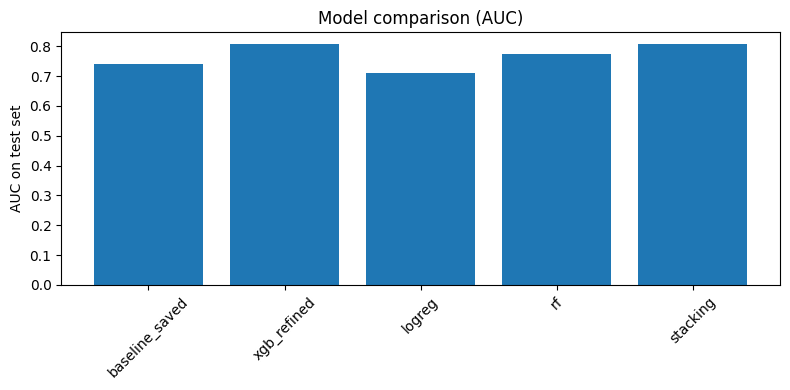

Done. Results saved to reports\model_comparison_refined.json
Models saved to models


In [52]:
# Day 8 — Hyperparameter Refinement & Ensemble (Jupyter-friendly, fixed)
# Paste entire cell into a notebook. Edit DATA_DIR and TRIALS if desired.

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import json
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# ML libs
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier

# ---------------- CONFIG ----------------
MODEL_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\models")
FEATURE_LIST_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\artifacts")
CLEANED_PATH = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy\artifacts")  # <-- set this
MODEL_PATH = MODEL_PATH / "xgboost_best.joblib"
FEATURE_LIST_PATH = FEATURE_LIST_PATH / "feature_list.txt"
CLEANED_PATH = CLEANED_PATH / "cleaned_strict.csv"
ENCODINGS_PATH = CLEANED_PATH / "encodings.json"

OUT_DIR = Path("reports")
OUT_DIR.mkdir(exist_ok=True)
MODEL_OUT = Path("models")
MODEL_OUT.mkdir(exist_ok=True)

RESULT_JSON = OUT_DIR / "model_comparison_refined.json"
TRIALS = 80  # change to 100+ for longer tuning

# ---------------- helpers (reuse patterns) ----------------
def load_feature_list(p):
    with open(p, "r") as f:
        return [l.strip() for l in f if l.strip()]

def load_json_if_exists(p):
    if p.exists():
        try:
            return json.load(open(p, "r"))
        except Exception:
            return None
    return None

def detect_model_expected_columns(model, fallback_feature_list):
    expected = None
    try:
        if hasattr(model, "feature_names_in_"):
            expected = list(model.feature_names_in_)
    except Exception:
        pass
    try:
        if expected is None and hasattr(model, "get_booster"):
            booster = model.get_booster()
            if hasattr(booster, "feature_names") and booster.feature_names is not None:
                expected = list(booster.feature_names)
    except Exception:
        pass
    if expected is None:
        expected = [f for f in fallback_feature_list if f != "approved_flag"]
    return expected

def build_X_proc_from_raw(X_raw, model_expected, encodings=None):
    X_proc = pd.DataFrame(index=X_raw.index)
    for feat in model_expected:
        if feat in X_raw.columns:
            X_proc[feat] = X_raw[feat]
            continue
        if feat.endswith("_enc"):
            raw_candidate = feat.replace("_enc", "")
            candidates = [raw_candidate, raw_candidate + "_1", "derived_" + raw_candidate, raw_candidate.replace("derived_", "")]
            found = next((c for c in candidates if c in X_raw.columns), None)
            if found:
                enc_map = encodings.get(feat) if isinstance(encodings, dict) else None
                if enc_map:
                    try:
                        mapped = X_raw[found].map(lambda x: enc_map.get(str(x), np.nan))
                        if mapped.notna().sum() > 0:
                            X_proc[feat] = mapped.fillna(mapped.median() if pd.api.types.is_numeric_dtype(mapped) else 0)
                            continue
                    except Exception:
                        pass
                try:
                    codes = pd.Categorical(X_raw[found]).codes
                    X_proc[feat] = pd.Series(codes, index=X_raw.index).astype(float)
                    continue
                except Exception:
                    pass
        X_proc[feat] = 0.0
    # coerce & fill
    for c in X_proc.columns:
        if X_proc[c].dtype == "object":
            coerced = pd.to_numeric(X_proc[c], errors="coerce")
            if coerced.notna().sum() > 0:
                X_proc[c] = coerced
            else:
                X_proc[c] = pd.Categorical(X_proc[c]).codes.astype(float)
    for c in X_proc.columns:
        if pd.api.types.is_numeric_dtype(X_proc[c]):
            if X_proc[c].isna().any():
                med = X_proc[c].median()
                X_proc[c] = X_proc[c].fillna(0.0 if pd.isna(med) else med)
        else:
            X_proc[c] = X_proc[c].fillna(0)
    X_proc = X_proc.reindex(columns=model_expected)
    return X_proc

def eval_metrics(y_true, y_prob, cutoff=0.5):
    y_pred = (y_prob >= cutoff).astype(int)
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "auc": float(roc_auc_score(y_true, y_prob))
    }

# ---------------- load data & baseline model ----------------
print("Loading data and baseline model...")
baseline_model = joblib.load(MODEL_PATH)
feature_list = load_feature_list(FEATURE_LIST_PATH)
encodings = load_json_if_exists(ENCODINGS_PATH)
df = pd.read_csv(CLEANED_PATH)
if "approved_flag" not in df.columns:
    raise RuntimeError("approved_flag target missing")
y = df["approved_flag"].astype(int)
X_raw = df.drop(columns=["approved_flag"])

# align features
model_expected = detect_model_expected_columns(baseline_model, feature_list)
print("Model expected features:", len(model_expected))
X_proc = build_X_proc_from_raw(X_raw, model_expected, encodings=encodings)
print("Prepared X_proc shape:", X_proc.shape)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42, stratify=y)

# ---------------- Optuna tuning for XGBoost (fixed: CV-based objective) ----------------
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "use_label_encoder": False,
        "verbosity": 0,
        "random_state": 42,
        "n_jobs": 4
    }
    clf = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    # use cross_val_score (roc_auc) for a stable metric
    scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=1)
    return float(scores.mean())

print(f"Starting Optuna tuning ({TRIALS} trials)...")
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=TRIALS, show_progress_bar=True)

best_params = study.best_params
print("Best params:", best_params)

# train best XGB on full training set (no early_stopping args)
best_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="auc", random_state=42, n_jobs=4)
best_xgb.fit(X_train, y_train)
joblib.dump(best_xgb, MODEL_OUT / "xgb_refined.joblib")

# ---------------- Train other models (LogReg, RF) ----------------
print("Training Logistic Regression and Random Forest baselines...")
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_lr.fit(X_train, y_train)
joblib.dump(pipe_lr, MODEL_OUT / "logreg.joblib")

rf = RandomForestClassifier(n_estimators=200, n_jobs=4, random_state=42)
rf.fit(X_train, y_train)
joblib.dump(rf, MODEL_OUT / "rf.joblib")

# ---------------- Stacking ensemble ----------------
print("Building stacking ensemble (LogReg + RF + XGB)...")
estimators = [
    ("lr", pipe_lr),
    ("rf", rf),
    ("xgb", best_xgb)
]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=1, passthrough=False)
stack.fit(X_train, y_train)

joblib.dump(stack, MODEL_OUT / "stacking.joblib")

# ---------------- Evaluate models on test set ----------------
print("Evaluating models on holdout test set...")
models = {
    "baseline_saved": baseline_model,
    "xgb_refined": best_xgb,
    "logreg": pipe_lr,
    "rf": rf,
    "stacking": stack
}
results = {}
for name, m in models.items():
    try:
        if hasattr(m, "predict_proba"):
            probs = m.predict_proba(X_test)[:,1]
        else:
            # xgboost.Booster may require DMatrix
            if hasattr(m, "get_booster"):
                dm = xgb.DMatrix(X_test)
                probs = m.get_booster().predict(dm)
            else:
                probs = m.predict(X_test)
        results[name] = eval_metrics(y_test, probs)
        results[name]["n_test"] = int(len(y_test))
        print(f"{name}: auc={results[name]['auc']:.4f} recall={results[name]['recall']:.4f} acc={results[name]['accuracy']:.4f}")
    except Exception as e:
        print("Eval failed for", name, e)

# ---------------- Include Day 7 ablation results if present ----------------
day7_ablation = load_json_if_exists(Path("reports") / "ablation_results.json")
if day7_ablation is not None:
    print("Including Day 7 ablation results in final report.")
else:
    print("No Day 7 ablation_results.json found in reports/")

# ---------------- Save combined results & simple plots ----------------
final_report = {
    "study_best_params": best_params,
    "models_evaluation_test": results,
    "optuna_study_stats": {
        "n_trials": len(study.trials),
        "best_value": study.best_value
    },
    "day7_ablation_results": day7_ablation
}

RESULT_JSON.parent.mkdir(parents=True, exist_ok=True)
with open(RESULT_JSON, "w") as fh:
    json.dump(final_report, fh, indent=2)

# simple comparison plot (AUC)
plt.figure(figsize=(8,4))
names = list(results.keys())
aucs = [results[n]["auc"] if results[n].get("auc") is not None else 0.0 for n in names]
plt.bar(names, aucs)
plt.ylabel("AUC on test set")
plt.title("Model comparison (AUC)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_DIR / "model_comparison_auc.png", dpi=200)
plt.show()
plt.close()

print("Done. Results saved to", RESULT_JSON)
print("Models saved to", MODEL_OUT)


In [53]:
import json, pandas as pd
from pathlib import Path
BASE = Path(r"C:\Users\meghr\OneDrive\Desktop\Loan Eligibiliy")
E = BASE / "artifacts" / "encodings.json"
C = BASE / "artifacts" / "cleaned_strict.csv"
print("encodings exists:", E.exists())
if E.exists():
    j = json.load(open(E,'r',encoding='utf-8'))
    for k in ["loan_type", "loan_type_enc", "loan_purpose", "loan_purpose_enc", "occupancy_type", "occupancy_type_enc", "property_type", "property_type_enc"]:
        if k in j:
            print("---", k, ":", type(j[k]).__name__)
            print(j[k])
        else:
            matches = [kk for kk in j.keys() if k.replace("_enc","") in kk.lower()]
            if matches:
                for m in matches:
                    print("match", m, type(j[m]).__name__, j[m])
            else:
                print(k, "NOT FOUND")
else:
    print("No encodings.json found")
print("cleaned exists:", C.exists())
if C.exists():
    df = pd.read_csv(C, nrows=1000, low_memory=False)
    for col in df.columns:
        if any(x in col.lower() for x in ["loan_type","loan_purpose","occupancy","property"]):
            print("CLEANED column:", col, "sample unique:", df[col].dropna().unique()[:20])


encodings exists: True
match loan_type_enc dict {'1': 0.9985997199439888, '3': 0.0014002800560112022}
--- loan_type_enc : dict
{'1': 0.9985997199439888, '3': 0.0014002800560112022}
match loan_purpose_enc dict {'2': 0.5443088617723545, '4': 0.21244248849769953, '31': 0.20484096819363873, '1': 0.03800760152030406, '32': 0.00040008001600320064}
--- loan_purpose_enc : dict
{'2': 0.5443088617723545, '4': 0.21244248849769953, '31': 0.20484096819363873, '1': 0.03800760152030406, '32': 0.00040008001600320064}
match occupancy_type_enc dict {'1': 0.9857971594318864, '2': 0.012002400480096018, '3': 0.0022004400880176033}
--- occupancy_type_enc : dict
{'1': 0.9857971594318864, '2': 0.012002400480096018, '3': 0.0022004400880176033}
match property_type_enc dict {'__MISSING__': 1.0}
--- property_type_enc : dict
{'__MISSING__': 1.0}
cleaned exists: True
CLEANED column: loan_type sample unique: [1]
CLEANED column: loan_purpose sample unique: [31  2  4  1]
CLEANED column: property_value sample unique: [